In [1]:
from google.colab import drive
drive.mount('/content/drive/')

%cd '/content/drive/My Drive/IS450/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/IS450


### Import relevant libraries

In [2]:
import pandas as pd
from datetime import datetime

import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords, wordnet
from nltk.util import ngrams

import re

from textwrap import wrap

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV,train_test_split, KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import pickle

import itertools

import gensim.downloader as api
import gensim.corpora as corpora

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from collections import Counter

import numpy as np

!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import time

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Functions

#### Text Cleaning Functions

In [0]:
def get_date(created):
    '''
    This function is to convert timestamp from UNIX
    '''
    return dt.datetime.fromtimestamp(created)

def lower_case(feedback):
    return feedback.lower()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

# remove all stop words and remove null
def remove_stopwords(feedback):
    stop_list = ['nil','gnil','nah','na','nan','haha','uhm','hehe']
    
    return [word for word in feedback if word not in stop_list]

def remove_symbols(feedback):
    whitelist = []
    return [re.sub(r'([^a-zA-Z0-9\s]+?)',' ',word) for word in feedback if word not in whitelist]

def remove_short_words(feedback):
    return [word for word in feedback if len(word) > 1]

def remove_apostrophes(feedback):
    return [re.sub(r"'s", "",word) for word in feedback]

def remove_digits(feedback):
    whitelist = []
    return [re.sub(r'\d+','',word) for word in feedback if word not in whitelist]

def remove_multispaces(feedback):
    #Replace multiple spaces with only 1 space
    return [re.sub(r' +', " ",word) for word in feedback]

def keep_alphanum(feedback):
    return [word for word in feedback if word.isalnum()]

def remove_consecutive(feedback):
    white_list = []
    return [re.sub(r'([a-z])\1\1+', r'\1\1',word) for word in feedback if word not in white_list]

def remove_duplicates_in_sentence(feedback):
    # remove duplicates
    return re.sub(r'\b(\w+)( \1\b)+', r'\1', feedback)

def normalize_word(feedback):
    replacement_dict = {'mdm':'professor','perfecto':'perfect','perfection':'perfect','pls':'please', 'mins':'minute',
                        '15mins':'minute','abit':'a bit','thanks':'thank you','ty':'thank you','tks':'thank you',
                        'bc':'because','alittle':'a little','lil':'little','e.g.':'example','e.g':'example',
                        'i.e.':'example','i.e':'example','dunno':'do not know','perfectoo':'perfect','organisation':'organization',
                        'organisational':'organizational','alt+tab':'alt tab','pr0f':'professor','qn':'question','qns':'question','3/3':'',
                        'perfectooo':'perfect','nil.prof':'nil. prof', 'none':'','gdd':'good',':/':'',':d':'',':o':'',
                        '&':' and ','/':' or ','prof':'professor','thr':'there','proff':'professor','pleaseeeee':'please','hmmmmmmmmmm':''}
    feedback = [replacement_dict[word] if word in replacement_dict.keys() else word for word in feedback]
    feedback = remove_consecutive(feedback)

    return feedback

def lemmatize_words(feedback):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    # Pos tagging
    nltk_tagged = nltk.pos_tag(feedback)  

    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
        
    # lemmatizing 
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is not None and word not in stopwords.words('english'):
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
        else:
            lemmatized_sentence.append(word)

    return (lemmatized_sentence)

# need to do the contractions dictionary
def expand_contractions(feedback):
    contractions = {"'cause": 'because',
                    "I'd": 'I would',
                    "I'd've": 'I would have',
                    "I'll": 'I will',
                    "I'll've": 'I will have',
                    "I'm": 'I am',
                    "I've": 'I have',
                    "ain't": 'am not',
                    "aren't": 'are not',
                    "can't": 'cannot',
                    "can't've": 'cannot have',
                    "could've": 'could have',
                    "couldn't": 'could not',
                    "couldn't've": 'could not have',
                    "didn't": 'did not',
                    "doesn't": 'does not',
                    "don't": 'do not',
                    "hadn't": 'had not',
                    "hadn't've": 'had not have',
                    "hasn't": 'has not',
                    "haven't": 'have not',
                    "he'd": 'he had',
                    "he'd've": 'he would have',
                    "he'll": 'he will',
                    "he'll've": 'he will have',
                    "he's": 'he is',
                    "how'd": 'how did',
                    "how'd'y": 'how do you',
                    "how'll": 'how will',
                    "how's": 'how is',
                    "i'd": 'i would',
                    "i'd've": 'i would have',
                    "i'll": 'i will',
                    "i'll've": 'i will have',
                    "i'm": 'i am',
                    "i've": 'i have',
                    "isn't": 'is not',
                    "it'd": 'it would',
                    "it'd've": 'it would have',
                    "it'll": 'it will',
                    "it'll've": 'it will have',
                    "it's": 'it is',
                    "let's": 'let us',
                    "ma'am": 'madam',
                    "mayn't": 'may not',
                    "might've": 'might have',
                    "mightn't": 'might not',
                    "mightn't've": 'might not have',
                    "must've": 'must have',
                    "mustn't": 'must not',
                    "mustn't've": 'must not have',
                    "needn't": 'need not',
                    "needn't've": 'need not have',
                    "o'clock": 'of the clock',
                    "oughtn't": 'ought not',
                    "oughtn't've": 'ought not have',
                    "sha'n't": 'shall not',
                    "shan't": 'shall not',
                    "shan't've": 'shall not have',
                    "she'd": 'she would',
                    "she'd've": 'she would have',
                    "she'll": 'she will',
                    "she'll've": 'she will have',
                    "she's": 'she is',
                    "should've": 'should have',
                    "shouldn't": 'should not',
                    "shouldn't've": 'should not have',
                    "so's": 'so as',
                    "so've": 'so have',
                    "that'd": 'that would',
                    "that'd've": 'that would have',
                    "that's": 'that is',
                    "there'd": 'there had',
                    "there'd've": 'there would have',
                    "there's": 'there is',
                    "they'd": 'they would',
                    "they'd've": 'they would have',
                    "they'll": 'they will',
                    "they'll've": 'they will have',
                    "they're": 'they are',
                    "they've": 'they have',
                    "to've": 'to have',
                    "wasn't": 'was not',
                    "we'd": 'we would',
                    "we'd've": 'we would have',
                    "we'll": 'we will',
                    "we'll've": 'we will have',
                    "we're": 'we are',
                    "we've": 'we have',
                    "weren't": 'were not',
                    "what'll": 'what will',
                    "what'll've": 'what will have',
                    "what're": 'what are',
                    "what's": 'what is',
                    "what've": 'what have',
                    "when's": 'when is',
                    "when've": 'when have',
                    "where'd": 'where did',
                    "where's": 'where is',
                    "where've": 'where have',
                    "who'll": 'who will',
                    "who'll've": 'who will have',
                    "who's": 'who is',
                    "who've": 'who have',
                    "why's": 'why is',
                    "why've": 'why have',
                    "will've": 'will have',
                    "won't": 'will not',
                    "won't've": 'will not have',
                    "would've": 'would have',
                    "wouldn't": 'would not',
                    "wouldn't've": 'would not have',
                    "y'all": 'you all',
                    "y'all'd": 'you all would',
                    "y'all'd've": 'you all would have',
                    "y'all're": 'you all are',
                    "y'all've": 'you all have',
                    "y'alls": 'you alls',
                    "you'd": 'you would',
                    "you'd've": 'you would have',
                    "you'll": 'you will',
                    "you'll've": 'you you will have',
                    "you're": 'you are',
                    "you've": 'you have'}
    return [contractions[word] if word in contractions.keys() else word for word in feedback]

def remove_duplicates_in_sentence(feedback):
    # remove duplicates
    return re.sub(r'\b(\w+)( \1\b)+', r'\1', feedback)

def clean_text(feedbacks):
    new_feedbacks = [lower_case(str(feedback)) for feedback in feedbacks]
    new_feedbacks = [nltk.word_tokenize(str(feedback)) for feedback in new_feedbacks]
    new_feedbacks = [remove_digits(feedback) for feedback in new_feedbacks]
    new_feedbacks = [normalize_word(feedback) for feedback in new_feedbacks]
    
    new_feedbacks = [expand_contractions(feedback) for feedback in new_feedbacks]
    new_feedbacks = [remove_apostrophes(feedback) for feedback in new_feedbacks]
    
    new_feedbacks = [remove_symbols(feedback) for feedback in new_feedbacks]
    new_feedbacks = [remove_multispaces(feedback) for feedback in new_feedbacks]
    
    new_feedbacks = [' '.join(feedback) for feedback in new_feedbacks]
    new_feedbacks = [nltk.word_tokenize(str(feedback)) for feedback in new_feedbacks]
    
    new_feedbacks = [lemmatize_words(feedback) for feedback in new_feedbacks]
    new_feedbacks = [remove_stopwords(feedback) for feedback in new_feedbacks]
    new_feedbacks = [remove_short_words(feedback) for feedback in new_feedbacks]
    new_feedbacks = [' '.join(feedback) for feedback in new_feedbacks]
    new_feedbacks = [remove_duplicates_in_sentence(str(feedback)) for feedback in new_feedbacks]

    return new_feedbacks


def remove_text(df,col):
    # # replace values for the following
    remove_lines = ['too early to discover','nothing as of now','no','today very good','week reflection','name',
                    'nothing','no comment','nope','week'
                    ]
    df = df[~df[col].isin(remove_lines)]                 
    return df

### Preliminary Feature Engineering

#### Load cleaned dataset

In [0]:
cleaned_feedback_df = pd.read_csv('cleaned_feedback.csv')
cleaned_feedback_df

,Timestamp,Name,Class Section,List one topic of the class that you enjoy,What was the most challenging topic of the class?,"Overall, the learning experience for the class is",(Optional) What do you suggest to improve the class?,cleaned_List one topic of the class that you enjoy,cleaned_What was the most challenging topic of the class?,cleaned_(Optional) What do you suggest to improve the class?
0,10/1/2019 11:14,Student249,G4 (Tue 8:15 - 11:30 SR 3.4),Solution blueprinting,Solution overview model,3,There are too many diagrams. Takes a long time...,solution blueprinting,solution overview model,there are too many diagram take long time to s...
1,10/1/2019 11:14,Student60,G4 (Tue 8:15 - 11:30 SR 3.4),Solution Overview Model,Blueprint,3,NaN,solution overview model,blueprint,NaN
2,10/1/2019 11:14,Student76,G4 (Tue 8:15 - 11:30 SR 3.4),Solution overview model,Teaching case 5 ( Looking for errors),3,NaN,solution overview model,teach case look for error,NaN
3,10/1/2019 11:14,Student56,G4 (Tue 8:15 - 11:30 SR 3.4),Application,Solution overview model,3,-,application,solution overview model,NaN
4,10/1/2019 11:14,Student49,G4 (Tue 8:15 - 11:30 SR 3.4),application model,solution overview,2,NaN,application model,solution overview,NaN
...,...,...,...,...,...,...,...,...,...,...
3092,9/9/2019 11:30,Student43,G1 (Mon 8:15 - 11:30 SR 3.2),I enjoyed learning about the RCI today because...,I really really enjoyed learning about Signavi...,4,More labs to enable us to discover the usage o...,enjoy learn about the rci today because it ena...,really enjoy learn about signavio through inst...,more lab to enable us to discover the usage of...
3093,9/9/2019 11:32,Student33,G1 (Mon 8:15 - 11:30 SR 3.2),Static Reports,Root Cause Impact Model,4,Allocate more time for labs/ go through labs a...,static report,root cause impact model,allocate more time for lab go through lab at s...
3094,9/9/2019 11:32,Student28,G1 (Mon 8:15 - 11:30 SR 3.2),RCI Model,Coming up with the RCR Model,3,Would appreciate if the lab lessons can be con...,rci model,come up with the rcr model,would appreciate if the lab lesson can be cond...
3095,9/9/2019 11:32,Student27,G1 (Mon 8:15 - 11:30 SR 3.2),One topic i really enjoyed was the Root Cause ...,The most challenging topic would be the lab ex...,4,More time allocated for the lab exercise and t...,one topic really enjoy was the root cause impa...,the most challenging topic would be the lab ex...,more time allocate for the lab exercise and th...


#### Weeks

In [0]:
cleaned_feedback_df['Date'] = pd.to_datetime(cleaned_feedback_df['Timestamp'], errors='coerce').dt.date
cleaned_feedback_df = cleaned_feedback_df.sort_values(by=['Date']).reset_index().drop(columns="index")
initial_date = min(cleaned_feedback_df['Date'])
end_date = max(cleaned_feedback_df['Date'])
bins = (list(np.arange(initial_date, end_date, 7)))
# print(bins)
new_bins = {}
weeks = []
for i in range(len(bins)):
    for j in range(7):
        if i + 1 not in new_bins:
            new_bins[i+1] = [bins[i] +j]
        else:
            new_bins[i+1].append(bins[i] + j)
for index,row in cleaned_feedback_df.iterrows():
    for index,value in new_bins.items():
        if row['Date'] in value:
            weeks.append(index)
cleaned_feedback_df['Week'] = weeks
cleaned_feedback_df.head()
cleaned_feedback_df.to_csv('Assignment.csv',index=False)

#### Class Type (Morning, Afternoon, Evening)

In [0]:
cleaned_feedback_df['Class Type'] = 0
cleaned_feedback_df['Class Type'][cleaned_feedback_df['Class Section'].str.contains("8:15 - 11:30")] = "Morning"
cleaned_feedback_df['Class Type'][cleaned_feedback_df['Class Section'].str.contains("12:00 - 15:15")] = "Afternoon"
cleaned_feedback_df['Class Type'][cleaned_feedback_df['Class Section'].str.contains("15:30 - 18:45")] = "Evening"

#### Sentiment Analysis for individual feedback before merging

In [0]:
sid = SentimentIntensityAnalyzer()

suggest_compound = []

for index,row in cleaned_feedback_df.iterrows():
    # row['(Optional) What do you suggest to improve the class?'] = emo_to_str(row['(Optional) What do you suggest to improve the class?'])
    suggestion = str(row['(Optional) What do you suggest to improve the class?'])
    suggest_compound.append(sid.polarity_scores(suggestion)["compound"])

cleaned_feedback_df['suggest_compound'] = suggest_compound
cleaned_feedback_df.head()

,Timestamp,Name,Class Section,List one topic of the class that you enjoy,What was the most challenging topic of the class?,"Overall, the learning experience for the class is",(Optional) What do you suggest to improve the class?,cleaned_List one topic of the class that you enjoy,cleaned_What was the most challenging topic of the class?,cleaned_(Optional) What do you suggest to improve the class?,Date,Week,Class Type,suggest_compound
0,8/19/2019 11:18:13,Student1,G1 (Mon 8:15 - 11:30 SR 3.2),The business process management,The various organisation models,4,-,the business process management,the various organization model,NaN,2019-08-19,1,Morning,0.0000
1,8/19/2019 11:21:42,Student25,G1 (Mon 8:15 - 11:30 SR 3.2),Understanding the need of the different biz pr...,none so far so good,4,NaN,understand the need of the different biz proce...,so far so good,NaN,2019-08-19,1,Morning,0.0000
2,8/19/2019 11:22:04,Student26,G1 (Mon 8:15 - 11:30 SR 3.2),Business processes,Location model,3,"Speak slower, handwriting can be more clear, p...",business process,location model,speak slow handwriting can be more clear point...,2019-08-19,1,Morning,0.4391
3,8/19/2019 11:22:15,Student27,G1 (Mon 8:15 - 11:30 SR 3.2),The class discussions about the organisational...,"The components of the business process, as i d...",4,There could be more class discussions as it wa...,the class discussion about the organizational ...,the component of the business process as did n...,there could be more class discussion as it was...,2019-08-19,1,Morning,0.7845
4,8/19/2019 11:22:28,Student28,G1 (Mon 8:15 - 11:30 SR 3.2),The alignment of businesses and IT,Sub process concept,3,nil,the alignment of business and it,sub process concept,NaN,2019-08-19,1,Morning,0.0000


### Assignment

#### Load Assignment datasets

In [0]:
assignment1_df = pd.read_csv('Assignment 1.csv',encoding = 'ISO-8859-1')
# display(assignment1_df)
assignment2_df = pd.read_csv('Assignment 2.csv',encoding = 'ISO-8859-1')
# display(assignment2_df)

# print(len(assignment1_df),len(assignment2_df))

assignment_df = pd.merge(assignment1_df, assignment2_df,left_on='StudentID',right_on='ID')
assignment_df = assignment_df.drop(columns='ID')
print(len(assignment_df))

components = {}
total = 0
for column in assignment_df:
    if column != 'StudentID':
        max_score = max(assignment_df[column])
        components[column] = max_score
        total += max_score
assignment_df['Total'] = assignment_df['Use Case Model']+assignment_df['Function model']+assignment_df['Solution overview model']+ assignment_df['Application model'] + assignment_df['Process Innovation'] + assignment_df['Business Model'] + assignment_df['Process Architecture'] + assignment_df['Process Model'] + assignment_df['Business goals strategy'] +assignment_df['Workflow diagram'] + assignment_df['Static analysis'] + assignment_df['Recommendations']

assignment_df.head()
display(assignment_df)
assignment_df.to_csv('Assignment.csv',index=False)

373


,StudentID,Use Case Model,Function model,Solution overview model,Application model,Process Innovation,Business Model,Process Architecture,Process Model,Business goals strategy,Workflow diagram,Static analysis,Recommendations,Total
0,Student41,3.0,3.0,2.5,3.0,2.5,3.0,2.0,3.0,1.5,3,2.0,2.0,30.5
1,Student21,2.5,3.0,3.0,1.0,2.5,3.0,2.0,3.0,1.5,4,1.5,2.0,29.0
2,Student17,1.5,1.5,3.0,3.0,0.0,3.0,2.0,3.0,2.0,4,2.0,2.0,27.0
3,Student9,2.5,2.5,3.0,2.0,3.0,3.0,0.5,3.0,1.0,5,1.0,2.0,28.5
4,Student38,1.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0,0.5,3,1.5,2.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,Student343,1.5,0.5,1.5,0.0,2.5,1.5,2.0,3.0,1.0,4,1.5,2.0,21.0
369,Student327,3.0,1.0,1.0,2.0,1.5,2.0,0.0,2.0,1.0,3,2.0,2.0,20.5
370,Student340,2.5,1.0,0.0,0.5,1.0,3.0,2.0,3.0,1.5,5,1.0,2.0,22.5
371,Student333,1.0,3.0,3.0,2.0,3.5,3.0,2.0,3.0,1.5,5,1.5,2.0,30.5


#### Assigning grade score for each student

In [0]:
assignment_df['grade'] = 0
assignment_df['grade'][assignment_df['Total'] < 17.5 ] = "F"
assignment_df['grade'][assignment_df['Total'] >= 17.5] = "D"
assignment_df['grade'][assignment_df['Total'] > 21] = "C"
assignment_df['grade'][assignment_df['Total'] > 24.5] = "B"
assignment_df['grade'][assignment_df['Total'] > 28] = "A"

#### Correlation for Grades

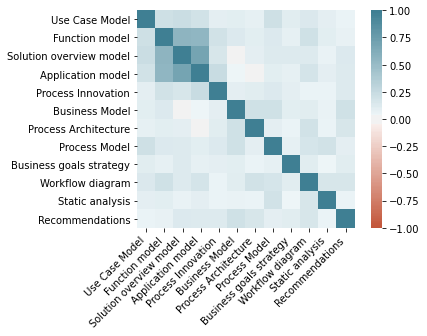

In [0]:
corr_df = assignment_df.copy()
corr_df.drop('Total',axis=1,inplace=True)
corr = corr_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [0]:
for index,row in corr.iterrows():
    for column in corr.columns:
        if index != column and row[column] > 0.5:
            print('{} with {} - {}'.format(index,column,row[column]))

print(components)

Function model with Solution overview model - 0.5601686570622921
Function model with Application model - 0.5410258723810948
Solution overview model with Function model - 0.5601686570622921
Solution overview model with Application model - 0.6927955768753346
Application model with Function model - 0.5410258723810948
Application model with Solution overview model - 0.6927955768753346
{'Use Case Model': 3.0, 'Function model': 3.0, 'Solution overview model': 3.0, 'Application model': 3.0, 'Process Innovation': 4.0, 'Business Model': 3.0, 'Process Architecture': 2.0, 'Process Model': 3.0, 'Business goals strategy': 2.0, 'Workflow diagram': 5, 'Static analysis': 2.0, 'Recommendations': 2.0}


### Model Feature Engineering

#### Drop extra students who do not have assignment grades

In [0]:
feedback_students = list(set(cleaned_feedback_df['Name']))
assignment_students = list(set(assignment_df['StudentID']))

extra_students = []
for feedback_student in feedback_students:
    if feedback_student not in assignment_students:
        extra_students.append(feedback_student)
cleaned_feedback_df = cleaned_feedback_df[~cleaned_feedback_df['Name'].isin(extra_students)]

#### Combine all feedbacks & proportion of length of feedback

In [0]:
all_feedbacks = []
feedback_length = []
total_feedback = 0
all_unclean_feedbacks = []

cleaned_feedback_df['cleaned_(Optional) What do you suggest to improve the class?'] = cleaned_feedback_df['cleaned_(Optional) What do you suggest to improve the class?'].fillna('')
for index,row in assignment_df.iterrows():
    current_df = cleaned_feedback_df[cleaned_feedback_df['Name'] == row['StudentID']]
    feedback = ''
    unclean_feedback = ''
    for current_index, current_row in current_df.iterrows():
        if current_row['cleaned_(Optional) What do you suggest to improve the class?'] not in ['nan','',' ']:
            feedback += str(current_row['cleaned_(Optional) What do you suggest to improve the class?']) + ' '
        unclean_feedback += str(current_row['(Optional) What do you suggest to improve the class?']) +  ' '
    all_unclean_feedbacks.append(unclean_feedback.strip())
    all_feedbacks.append(feedback.strip())
    feedback_length.append(len(feedback.strip()))
    total_feedback += len(feedback.strip())

assignment_df['feedback_length_proportion'] = [x/total_feedback for x in feedback_length]
assignment_df['all_feedback'] = all_feedbacks
assignment_df['all_feedback'] = assignment_df['all_feedback'].fillna(np.nan)
assignment_df['all_unclean_feedback'] = all_unclean_feedbacks
assignment_df['all_unclean_feedback'] = assignment_df['all_unclean_feedback'].fillna(np.nan)
assignment_df.head()
print(len(assignment_df))

373


#### Average Sentiment by Students

In [0]:
sid = SentimentIntensityAnalyzer()

compound = []

for index,row in cleaned_feedback_df.iterrows():
    if row['cleaned_(Optional) What do you suggest to improve the class?'] == '':
        compound.append(0)
    else:
        # feedback = row['(Optional) What do you suggest to improve the class?']
        feedback = row['cleaned_(Optional) What do you suggest to improve the class?']
        compound.append(sid.polarity_scores(feedback)["compound"])

cleaned_feedback_df['suggest_compound'] = compound

sentiment_df = cleaned_feedback_df.copy()
sentiment_df.nlargest(10, 'suggest_compound').to_csv('Sample_Sentiment_Checker (Positive).csv',index=False)

sentiment_df.nsmallest(10, 'suggest_compound').to_csv('Sample_Sentiment_Checker (Negative).csv',index=False)

# Standardize sentiment scores so that we can fit into MultinomialNB
cleaned_feedback_df['suggest_compound'] += 1

average_sentiment_score = cleaned_feedback_df[['Name','suggest_compound']].groupby(['Name']).mean().reset_index()
assignment_df = pd.merge(assignment_df,average_sentiment_score,left_on='StudentID',right_on='Name')
assignment_df.drop(columns='Name')
assignment_df

,StudentID,Use Case Model,Function model,Solution overview model,Application model,Process Innovation,Business Model,Process Architecture,Process Model,Business goals strategy,Workflow diagram,Static analysis,Recommendations,Total,grade,feedback_length_proportion,all_feedback,all_unclean_feedback,Name,suggest_compound
0,Student41,3.0,3.0,2.5,3.0,2.5,3.0,2.0,3.0,1.5,3,2.0,2.0,30.5,A,0.000000,,nan nan,Student41,1.000000
1,Student21,2.5,3.0,3.0,1.0,2.5,3.0,2.0,3.0,1.5,4,1.5,2.0,29.0,A,0.004338,more explanation on the activity as it is rath...,Nil nan nan nan More explanation on the activi...,Student21,1.026763
2,Student17,1.5,1.5,3.0,3.0,0.0,3.0,2.0,3.0,2.0,4,2.0,2.0,27.0,B,0.001307,more example to show the difference way of ide...,Nil Nil Nil More examples to show the differen...,Student17,1.000000
3,Student9,2.5,2.5,3.0,2.0,3.0,3.0,0.5,3.0,1.0,5,1.0,2.0,28.5,A,0.002823,please slow down professor during lab it was b...,"nil nil please slow down prof :D during lab, i...",Student9,1.099220
4,Student38,1.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0,0.5,3,1.5,2.0,14.0,F,0.001288,maybe the handwriting on the board some of the...,Maybe the handwriting on the board. Some of th...,Student38,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,Student343,1.5,0.5,1.5,0.0,2.5,1.5,2.0,3.0,1.0,4,1.5,2.0,21.0,D,0.000000,,nan nan nan nan nan nan nan nan nan nan,Student343,1.000000
369,Student327,3.0,1.0,1.0,2.0,1.5,2.0,0.0,2.0,1.0,3,2.0,2.0,20.5,D,0.003334,clarity of class activity example place bread ...,"NIL. Clarity of class activities. i.e. ""Placi...",Student327,1.040190
370,Student340,2.5,1.0,0.0,0.5,1.0,3.0,2.0,3.0,1.5,5,1.0,2.0,22.5,C,0.001857,visual representation and example more interac...,Visual representation & example More interacti...,Student340,1.000000
371,Student333,1.0,3.0,3.0,2.0,3.5,3.0,2.0,3.0,1.5,5,1.5,2.0,30.5,A,0.000000,,nan nan nan nan nan nan nan nan nan,Student333,1.000000


#### Frequency of Feedbacks

In [0]:
max_week = max(list(set(cleaned_feedback_df['Week'])))
feedback_group_df = cleaned_feedback_df[cleaned_feedback_df['cleaned_(Optional) What do you suggest to improve the class?'] != ''].groupby('Name').size().reset_index(name='number_feedback')
feedback_group_df['feedback_frequency'] = feedback_group_df['number_feedback'] / max_week

feedback_students = list(set(feedback_group_df['Name']))
assignment_students = list(set(assignment_df['Name']))

missing_students = []
for assignment_student in assignment_students:
    if assignment_student not in feedback_students:
        missing_students.append(assignment_student)
print(len(missing_students))
max_index = len(feedback_group_df)

for i in range(len(missing_students)):
    feedback_group_df.loc[max_index+i] = [missing_students[i]] + [0] + [0]

assignment_df = pd.merge(assignment_df,feedback_group_df,on='Name')
assignment_df

104


,StudentID,Use Case Model,Function model,Solution overview model,Application model,Process Innovation,Business Model,Process Architecture,Process Model,Business goals strategy,Workflow diagram,Static analysis,Recommendations,Total,grade,feedback_length_proportion,all_feedback,all_unclean_feedback,Name,suggest_compound,number_feedback,feedback_frequency
0,Student41,3.0,3.0,2.5,3.0,2.5,3.0,2.0,3.0,1.5,3,2.0,2.0,30.5,A,0.000000,,nan nan,Student41,1.000000,0,0.000000
1,Student21,2.5,3.0,3.0,1.0,2.5,3.0,2.0,3.0,1.5,4,1.5,2.0,29.0,A,0.004338,more explanation on the activity as it is rath...,Nil nan nan nan More explanation on the activi...,Student21,1.026763,2,0.153846
2,Student17,1.5,1.5,3.0,3.0,0.0,3.0,2.0,3.0,2.0,4,2.0,2.0,27.0,B,0.001307,more example to show the difference way of ide...,Nil Nil Nil More examples to show the differen...,Student17,1.000000,1,0.076923
3,Student9,2.5,2.5,3.0,2.0,3.0,3.0,0.5,3.0,1.0,5,1.0,2.0,28.5,A,0.002823,please slow down professor during lab it was b...,"nil nil please slow down prof :D during lab, i...",Student9,1.099220,2,0.153846
4,Student38,1.0,0.0,0.0,0.0,1.0,2.0,0.0,3.0,0.5,3,1.5,2.0,14.0,F,0.001288,maybe the handwriting on the board some of the...,Maybe the handwriting on the board. Some of th...,Student38,1.000000,1,0.076923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,Student343,1.5,0.5,1.5,0.0,2.5,1.5,2.0,3.0,1.0,4,1.5,2.0,21.0,D,0.000000,,nan nan nan nan nan nan nan nan nan nan,Student343,1.000000,0,0.000000
369,Student327,3.0,1.0,1.0,2.0,1.5,2.0,0.0,2.0,1.0,3,2.0,2.0,20.5,D,0.003334,clarity of class activity example place bread ...,"NIL. Clarity of class activities. i.e. ""Placi...",Student327,1.040190,3,0.230769
370,Student340,2.5,1.0,0.0,0.5,1.0,3.0,2.0,3.0,1.5,5,1.0,2.0,22.5,C,0.001857,visual representation and example more interac...,Visual representation & example More interacti...,Student340,1.000000,3,0.230769
371,Student333,1.0,3.0,3.0,2.0,3.5,3.0,2.0,3.0,1.5,5,1.5,2.0,30.5,A,0.000000,,nan nan nan nan nan nan nan nan nan,Student333,1.000000,0,0.000000


#### Class Distribution

In [0]:
class_df = cleaned_feedback_df.groupby('Class Section').size().reset_index(name='count')
class_df['Class Type'] = ''
class_df['Class Type'][class_df['Class Section'].str.contains("8:15 - 11:30")] = "Morning"
class_df['Class Type'][class_df['Class Section'].str.contains("12:00 - 15:15")] = "Afternoon"
class_df['Class Type'][class_df['Class Section'].str.contains("15:30 - 18:45")] = "Evening"
class_type_df = class_df.groupby('Class Type').size().reset_index(name='count')
class_type_df['class_proportion'] = class_type_df['count']/ class_type_df['count'].sum()
# class_types = []
# for class_type in cleaned_feedback_df['Class Type']:
#     class_types.append(float(class_type_df[class_type_df['Class Type']==class_type]['class_proportion']))
cleaned_feedback_df
# cleaned_feedback_df['class_proportion'] = class_types
# class_type_df = cleaned_feedback_df.groupby('Name')['class_proportion'].mean().reset_index(name='class_proportion')

temp_class_df = cleaned_feedback_df.groupby(['Name','Class Type']).size().reset_index(name='Count')
temp_class_df = temp_class_df[['Name','Class Type']]

class_type_df = pd.merge(class_type_df,temp_class_df,on='Class Type')
class_type_df.drop('count',axis=1,inplace=True)
class_type_df.drop_duplicates(subset ="Name", 
                     keep = 'first', inplace = True)
assignment_df = pd.merge(class_type_df,assignment_df,on='Name')
display(assignment_df)
print(len(assignment_df))

,Class Type,class_proportion,Name,StudentID,Use Case Model,Function model,Solution overview model,Application model,Process Innovation,Business Model,Process Architecture,Process Model,Business goals strategy,Workflow diagram,Static analysis,Recommendations,Total,grade,feedback_length_proportion,all_feedback,all_unclean_feedback,suggest_compound,number_feedback,feedback_frequency
0,Afternoon,0.111111,Student100,Student100,2.0,2.5,3.0,3.0,2.5,2.5,2.0,3.0,0.5,2,1.0,2.0,26.0,B,0.003467,perhaps walk us through an example of how to d...,nan nan nan nan nan nan Perhaps walking us thr...,1.091027,2,0.153846
1,Afternoon,0.111111,Student101,Student101,2.0,1.5,1.0,1.0,1.5,2.5,2.0,3.0,1.0,4,1.0,2.0,22.5,C,0.000777,more example and activity feedback please,nan nan nan nan nan More examples and activiti...,1.028927,2,0.153846
2,Afternoon,0.111111,Student102,Student102,2.5,3.0,2.0,2.5,3.0,3.0,1.0,3.0,1.0,4,1.0,2.0,28.0,B,0.000000,,nan nan nan nan nan nan nan nan nan,1.000000,0,0.000000
3,Afternoon,0.111111,Student103,Student103,2.5,2.5,2.5,2.0,2.0,3.0,1.5,3.0,1.5,3,1.5,2.0,27.0,B,0.003334,maybe can provide more example on the collabor...,- Maybe can provide more examples on the colla...,0.985927,2,0.153846
4,Afternoon,0.111111,Student104,Student104,3.0,2.5,3.0,2.5,2.5,3.0,2.0,3.0,2.0,3,2.0,2.0,30.5,A,0.002633,enjoy the class activity maybe more example an...,enjoyed the class activities maybe more exampl...,1.039120,4,0.307692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,Morning,0.666667,Student80,Student80,2.5,3.0,2.5,0.0,3.0,3.0,2.0,2.0,1.5,5,1.5,2.0,28.0,B,0.001762,go slow during the lab put the explanation of ...,nan NIL nan Go slower during the Lab Put the e...,1.041709,2,0.153846
369,Morning,0.666667,Student81,Student81,1.0,0.5,0.5,0.0,2.0,3.0,0.5,3.0,1.5,2,0.5,1.5,16.0,F,0.001099,go through one case together than follow by gr...,nan Nil nan nil nan Go through one case togeth...,1.000000,1,0.076923
370,Morning,0.666667,Student82,Student82,2.0,1.0,0.5,0.5,4.0,3.0,2.0,3.0,2.0,1,2.0,2.0,23.0,C,0.001212,have more time on in class activity especially...,nan nan nan nan nan have more time on in class...,1.000000,1,0.076923
371,Morning,0.666667,Student83,Student83,2.0,2.0,2.0,3.0,4.0,3.0,2.0,3.0,2.0,3,2.0,1.5,29.5,A,0.000000,,NIL nan nan nan nan nan nan nan nan nan nan,1.000000,0,0.000000


373


#### Fuzzy matching between enjoyable topic, challenging topic, feedback & assignment components

In [0]:
start = time.process_time()

content_df = pd.read_csv('IS210_Dictionary.csv',encoding = 'ISO-8859-1')

content_df['Concept'] = content_df['Concept'].str.lower()
print("Current Content Size before checking: {}\n".format(len(content_df)))
current_index = len(content_df)
new_components_name = list(components.keys())
new_components_name = [x.lower() for x in new_components_name][:len(new_components_name)-2] #take away total column
current_bullet = 1
for component_name in new_components_name:
    if component_name not in list(content_df['Concept']):
        print("{})".format(current_bullet),component_name,"is missing.")
        content_df.loc[current_index,'Concept'] = component_name
        current_index += 1
        current_bullet += 1
print("\nCurrent Content Size after checking: {}".format(len(content_df)))



columns = ['cleaned_List one topic of the class that you enjoy','cleaned_What was the most challenging topic of the class?','cleaned_(Optional) What do you suggest to improve the class?']

contents = list(content_df['Concept'])
for column in columns:
    fuzzy_scores = []
    for index,row in cleaned_feedback_df.iterrows():
        feedback = str(row[column])
        words = {1:[],2:[],3:[],4:[],5:[]}
        standardize = {1:1/5,2:2/5,3:3/5,4:4/5,5:1}
        if feedback != '':
            for i in range(1,5):
                grams = ngrams(feedback.split(), i)

                for gram in grams:
                    words[i].append(' '.join(gram))
            
            for content in contents:
                length = len(content.split())
                max_sim = 0
                for word in words[length]:
                    score = fuzz.ratio(word,content)
                    if score*standardize[length] > max_sim:
                        max_sim = score*standardize[length]

            # print('Average_score: {}'.format(avg_sim/100))
            fuzzy_scores.append(max_sim/100)
        else:
            fuzzy_scores.append(0)

    new_column = 'fuzzy_similarity_' + column 
    cleaned_feedback_df[new_column] = fuzzy_scores

for column in columns:
    new_column = 'fuzzy_similarity_' + column
    display(cleaned_feedback_df[[column,new_column]])
    filename = new_column + '_Checker.csv'
    cleaned_feedback_df.nlargest(10, new_column).to_csv(filename,index=False)

print('Run Time: {} seconds'.format(str((time.process_time() - start))))

Current Content Size before checking: 69


Current Content Size after checking: 69


,cleaned_List one topic of the class that you enjoy,fuzzy_similarity_cleaned_List one topic of the class that you enjoy
0,the business process management,0.366
1,understand the need of the different biz proce...,0.252
2,business process,0.000
3,the class discussion about the organizational ...,0.210
4,the alignment of business and it,0.426
...,...,...
3092,the innovative idea present by all the group w...,0.204
3093,usefulness of iot that can be implement in all...,0.264
3094,listen to the different presentation and what ...,0.174
3095,presentation of iot,0.138


,cleaned_What was the most challenging topic of the class?,fuzzy_similarity_cleaned_What was the most challenging topic of the class?
0,the various organization model,0.174
1,so far so good,0.180
2,location model,0.000
3,the component of the business process as did n...,0.366
4,sub process concept,0.240
...,...,...
3092,but fail to bid for you class,0.186
3093,present while my phone ringing,0.198
3094,prepare for the presentation,0.132
3095,understanding of workflow process,0.144


,cleaned_(Optional) What do you suggest to improve the class?,fuzzy_similarity_cleaned_(Optional) What do you suggest to improve the class?
0,,0.000
1,,0.000
2,speak slow handwriting can be more clear point...,0.264
3,there could be more class discussion as it was...,0.228
4,,0.000
...,...,...
3092,,0.000
3093,,0.000
3094,,0.000
3095,best professor,0.000


Run Time: 112.260016216 seconds


#### Topic Modelling

In [0]:
topic_df = pd.read_csv('student_topicdistribution.csv')
topic_df
assignment_df = pd.merge(topic_df,assignment_df,on='Name')
assignment_df

,Name,Challenging_Module 5 : Business Process Analysis (Static)_1,Challenging_Module 2 : Business IT Alignment,Challenging_Module 4: Business Process Modelling P2,Challenging_Module 7 : Business Process Solutioning (IT requirements)_1,Challenging_In class activities/presentation,Challenging_Module 7 : Business Process Solutioning (IT requirements)_2,Challenging_Module 5 : Business Process Analysis (Static)_2,Enjoy_In class presentations,Enjoy_Module 6 : Business Process Analysis (Dynamic),Enjoy_Module 5 : Business Process Analysis (Static)_1,Enjoy_Module 5 : Business Process Analysis (Static)_2,Enjoy_Module 4: Business Process Modelling P2_1,Enjoy_Module 4: Business Process Modelling P2_2,Class Type,class_proportion,StudentID,Use Case Model,Function model,Solution overview model,Application model,Process Innovation,Business Model,Process Architecture,Process Model,Business goals strategy,Workflow diagram,Static analysis,Recommendations,Total,grade,feedback_length_proportion,all_feedback,all_unclean_feedback,suggest_compound,number_feedback,feedback_frequency
0,Student1,0,1,1,0,1,0,2,1,1,0,2,0,2,Morning,0.666667,Student1,2.5,2.5,3.0,3.0,1.5,2.5,2.0,2.0,1.5,2,1.0,2.0,25.5,B,0.000000,,- - - - - - - -,1.000000,0,0.000000
1,Student10,0,1,1,0,0,0,0,1,0,0,0,0,2,Morning,0.666667,Student10,2.5,2.5,3.0,2.0,1.5,3.0,2.0,3.0,0.5,3,2.0,2.0,27.0,B,0.000606,more practice for use case model,Nil Nil Nil more practice for use case model,1.000000,1,0.076923
2,Student100,0,1,0,1,2,0,1,1,1,1,1,0,3,Afternoon,0.111111,Student100,2.0,2.5,3.0,3.0,2.5,2.5,2.0,3.0,0.5,2,1.0,2.0,26.0,B,0.003467,perhaps walk us through an example of how to d...,nan nan nan nan nan nan Perhaps walking us thr...,1.091027,2,0.153846
3,Student101,1,1,1,1,1,0,2,2,0,1,1,2,3,Afternoon,0.111111,Student101,2.0,1.5,1.0,1.0,1.5,2.5,2.0,3.0,1.0,4,1.0,2.0,22.5,C,0.000777,more example and activity feedback please,nan nan nan nan nan More examples and activiti...,1.028927,2,0.153846
4,Student102,1,1,0,1,1,1,0,1,0,0,0,1,4,Afternoon,0.111111,Student102,2.5,3.0,2.0,2.5,3.0,3.0,1.0,3.0,1.0,4,1.0,2.0,28.0,B,0.000000,,nan nan nan nan nan nan nan nan nan,1.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,Student95,0,1,0,0,2,0,1,1,1,0,0,1,4,Afternoon,0.111111,Student95,2.5,2.5,0.0,0.5,3.0,2.5,2.0,3.0,1.5,4,2.0,2.0,25.5,B,0.002065,nothing is good the lab is very confusing and ...,nan nothing! is gdd nan nan The lab is very co...,0.971491,2,0.153846
369,Student96,1,0,0,2,0,1,0,0,0,0,2,0,3,Afternoon,0.111111,Student96,2.0,0.5,0.5,0.0,2.5,3.0,2.0,3.0,2.0,3,2.0,1.5,22.0,C,0.000000,,nil nil nil nan nil nan nan nan nan nan nan,1.000000,0,0.000000
370,Student97,1,0,0,0,2,1,0,0,0,1,2,1,1,Afternoon,0.111111,Student97,2.5,1.5,3.0,3.0,1.5,2.5,1.0,3.0,1.5,5,1.0,2.0,27.5,B,0.001212,signavio take too much time lab felt really mu...,nan nan nan Signavio took too much time. Lab f...,1.062490,3,0.230769
371,Student98,0,0,0,0,0,0,3,1,1,1,0,0,4,Afternoon,0.111111,Student98,1.5,0.5,1.0,0.0,2.5,2.5,2.0,3.0,0.5,3,2.0,2.0,20.5,D,0.012163,checkpoint question to test understanding of c...,Checkpoint questions to test understanding of ...,1.079490,5,0.384615


#### Merge Dataset and offset those records with feedbacks which are cleaned till empty string to 0

In [0]:
similarity_df = cleaned_feedback_df.groupby('Name').agg({'fuzzy_similarity_cleaned_List one topic of the class that you enjoy':'sum',
                                                         'fuzzy_similarity_cleaned_What was the most challenging topic of the class?':'sum',
                                                         'fuzzy_similarity_cleaned_(Optional) What do you suggest to improve the class?':'sum'}).rename(columns={'fuzzy_similarity_cleaned_List one topic of the class that you enjoy': 'total_fuzzy_similarity_enjoy',
                                                         'fuzzy_similarity_cleaned_What was the most challenging topic of the class?':'total_fuzzy_similarity_challenge',
                                                         'fuzzy_similarity_cleaned_(Optional) What do you suggest to improve the class?':'total_fuzzy_similarity_suggest'}).reset_index()

assignment_df = pd.merge(similarity_df,assignment_df,on='Name')
assignment_df.loc[assignment_df['number_feedback'] == 0,'total_fuzzy_similarity_enjoy'] = 0
assignment_df.loc[assignment_df['number_feedback'] == 0,'total_fuzzy_similarity_challenge'] = 0
assignment_df.loc[assignment_df['number_feedback'] == 0,'total_fuzzy_similarity_suggest'] = 0
assignment_df.loc[assignment_df['number_feedback'] == 0,'suggest_compound'] = 0
assignment_df['avg_fuzzy_similarity_enjoy'] = assignment_df['total_fuzzy_similarity_enjoy']/assignment_df['number_feedback']
assignment_df['avg_fuzzy_similarity_challenge'] = assignment_df['total_fuzzy_similarity_challenge']/assignment_df['number_feedback']
assignment_df['avg_fuzzy_similarity_suggest'] = assignment_df['total_fuzzy_similarity_suggest']/assignment_df['number_feedback']
assignment_df['avg_fuzzy_similarity_enjoy'] = assignment_df['avg_fuzzy_similarity_enjoy'].fillna(0)
assignment_df['avg_fuzzy_similarity_challenge'] = assignment_df['avg_fuzzy_similarity_challenge'].fillna(0)
assignment_df['avg_fuzzy_similarity_suggest'] = assignment_df['avg_fuzzy_similarity_suggest'].fillna(0)

assignment_df.to_csv('Consolidated_Dataset_with_Feature_Engineering.csv',index=False)
display(assignment_df)
print(len(assignment_df))

,Name,total_fuzzy_similarity_enjoy,total_fuzzy_similarity_challenge,total_fuzzy_similarity_suggest,Challenging_Module 5 : Business Process Analysis (Static)_1,Challenging_Module 2 : Business IT Alignment,Challenging_Module 4: Business Process Modelling P2,Challenging_Module 7 : Business Process Solutioning (IT requirements)_1,Challenging_In class activities/presentation,Challenging_Module 7 : Business Process Solutioning (IT requirements)_2,Challenging_Module 5 : Business Process Analysis (Static)_2,Enjoy_In class presentations,Enjoy_Module 6 : Business Process Analysis (Dynamic),Enjoy_Module 5 : Business Process Analysis (Static)_1,Enjoy_Module 5 : Business Process Analysis (Static)_2,Enjoy_Module 4: Business Process Modelling P2_1,Enjoy_Module 4: Business Process Modelling P2_2,Class Type,class_proportion,StudentID,Use Case Model,Function model,Solution overview model,Application model,Process Innovation,Business Model,Process Architecture,Process Model,Business goals strategy,Workflow diagram,Static analysis,Recommendations,Total,grade,feedback_length_proportion,all_feedback,all_unclean_feedback,suggest_compound,number_feedback,feedback_frequency,avg_fuzzy_similarity_enjoy,avg_fuzzy_similarity_challenge,avg_fuzzy_similarity_suggest
0,Student1,0.000,0.000,0.000,0,1,1,0,1,0,2,1,1,0,2,0,2,Morning,0.666667,Student1,2.5,2.5,3.0,3.0,1.5,2.5,2.0,2.0,1.5,2,1.0,2.0,25.5,B,0.000000,,- - - - - - - -,0.000000,0,0.000000,0.0000,0.0000,0.0000
1,Student10,1.008,0.654,0.258,0,1,1,0,0,0,0,1,0,0,0,0,2,Morning,0.666667,Student10,2.5,2.5,3.0,2.0,1.5,3.0,2.0,3.0,0.5,3,2.0,2.0,27.0,B,0.000606,more practice for use case model,Nil Nil Nil more practice for use case model,1.000000,1,0.076923,1.0080,0.6540,0.2580
2,Student100,1.860,2.022,0.408,0,1,0,1,2,0,1,1,1,1,1,0,3,Afternoon,0.111111,Student100,2.0,2.5,3.0,3.0,2.5,2.5,2.0,3.0,0.5,2,1.0,2.0,26.0,B,0.003467,perhaps walk us through an example of how to d...,nan nan nan nan nan nan Perhaps walking us thr...,1.091027,2,0.153846,0.9300,1.0110,0.2040
3,Student101,2.304,1.956,0.114,1,1,1,1,1,0,2,2,0,1,1,2,3,Afternoon,0.111111,Student101,2.0,1.5,1.0,1.0,1.5,2.5,2.0,3.0,1.0,4,1.0,2.0,22.5,C,0.000777,more example and activity feedback please,nan nan nan nan nan More examples and activiti...,1.028927,2,0.153846,1.1520,0.9780,0.0570
4,Student102,0.000,0.000,0.000,1,1,0,1,1,1,0,1,0,0,0,1,4,Afternoon,0.111111,Student102,2.5,3.0,2.0,2.5,3.0,3.0,1.0,3.0,1.0,4,1.0,2.0,28.0,B,0.000000,,nan nan nan nan nan nan nan nan nan,0.000000,0,0.000000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,Student95,1.590,1.890,0.402,0,1,0,0,2,0,1,1,1,0,0,1,4,Afternoon,0.111111,Student95,2.5,2.5,0.0,0.5,3.0,2.5,2.0,3.0,1.5,4,2.0,2.0,25.5,B,0.002065,nothing is good the lab is very confusing and ...,nan nothing! is gdd nan nan The lab is very co...,0.971491,2,0.153846,0.7950,0.9450,0.2010
369,Student96,0.000,0.000,0.000,1,0,0,2,0,1,0,0,0,0,2,0,3,Afternoon,0.111111,Student96,2.0,0.5,0.5,0.0,2.5,3.0,2.0,3.0,2.0,3,2.0,1.5,22.0,C,0.000000,,nil nil nil nan nil nan nan nan nan nan nan,0.000000,0,0.000000,0.0000,0.0000,0.0000
370,Student97,2.292,1.398,0.498,1,0,0,0,2,1,0,0,0,1,2,1,1,Afternoon,0.111111,Student97,2.5,1.5,3.0,3.0,1.5,2.5,1.0,3.0,1.5,5,1.0,2.0,27.5,B,0.001212,signavio take too much time lab felt really mu...,nan nan nan Signavio took too much time. Lab f...,1.062490,3,0.230769,0.7640,0.4660,0.1660
371,Student98,0.474,0.564,1.164,0,0,0,0,0,0,3,1,1,1,0,0,4,Afternoon,0.111111,Student98,1.5,0.5,1.0,0.0,2.5,2.5,2.0,3.0,0.5,3,2.0,2.0,20.5,D,0.012163,checkpoint question to test understanding of c...,Checkpoint questions to test understanding of ...,1.079490,5,0.384615,0.0948,0.1128,0.2328


373


### Load Consolidated Dataset

In [4]:
cleaned_df = pd.read_csv('Consolidated_Dataset_with_Feature_Engineering.csv')
cleaned_df['all_feedback'] = cleaned_df['all_feedback'].fillna('')

# print(cleaned_df.columns)

for column in ['number_feedback','total_fuzzy_similarity_enjoy','total_fuzzy_similarity_challenge',
               'total_fuzzy_similarity_suggest','Name','Use Case Model',
       'Function model', 'Solution overview model', 'Application model',
       'Process Innovation', 'Business Model', 'Process Architecture',
       'Process Model', 'Business goals strategy', 'Workflow diagram',
       'Static analysis', 'Recommendations']:
    cleaned_df.drop(column, axis=1, inplace=True)

display(cleaned_df)
print(len(cleaned_df))

,Challenging_Module 5 : Business Process Analysis (Static)_1,Challenging_Module 2 : Business IT Alignment,Challenging_Module 4: Business Process Modelling P2,Challenging_Module 7 : Business Process Solutioning (IT requirements)_1,Challenging_In class activities/presentation,Challenging_Module 7 : Business Process Solutioning (IT requirements)_2,Challenging_Module 5 : Business Process Analysis (Static)_2,Enjoy_In class presentations,Enjoy_Module 6 : Business Process Analysis (Dynamic),Enjoy_Module 5 : Business Process Analysis (Static)_1,Enjoy_Module 5 : Business Process Analysis (Static)_2,Enjoy_Module 4: Business Process Modelling P2_1,Enjoy_Module 4: Business Process Modelling P2_2,Class Type,class_proportion,StudentID,Total,grade,feedback_length_proportion,all_feedback,all_unclean_feedback,suggest_compound,feedback_frequency,avg_fuzzy_similarity_enjoy,avg_fuzzy_similarity_challenge,avg_fuzzy_similarity_suggest
0,0,1,1,0,1,0,2,1,1,0,2,0,2,Morning,0.666667,Student1,25.5,B,0.000000,,- - - - - - - -,0.000000,0.000000,0.0000,0.0000,0.0000
1,0,1,1,0,0,0,0,1,0,0,0,0,2,Morning,0.666667,Student10,27.0,B,0.000606,more practice for use case model,Nil Nil Nil more practice for use case model,1.000000,0.076923,1.0080,0.6540,0.2580
2,0,1,0,1,2,0,1,1,1,1,1,0,3,Afternoon,0.111111,Student100,26.0,B,0.003467,perhaps walk us through an example of how to d...,nan nan nan nan nan nan Perhaps walking us thr...,1.091027,0.153846,0.9300,1.0110,0.2040
3,1,1,1,1,1,0,2,2,0,1,1,2,3,Afternoon,0.111111,Student101,22.5,C,0.000777,more example and activity feedback please,nan nan nan nan nan More examples and activiti...,1.028927,0.153846,1.1520,0.9780,0.0570
4,1,1,0,1,1,1,0,1,0,0,0,1,4,Afternoon,0.111111,Student102,28.0,B,0.000000,,nan nan nan nan nan nan nan nan nan,0.000000,0.000000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,0,1,0,0,2,0,1,1,1,0,0,1,4,Afternoon,0.111111,Student95,25.5,B,0.002065,nothing is good the lab is very confusing and ...,nan nothing! is gdd nan nan The lab is very co...,0.971491,0.153846,0.7950,0.9450,0.2010
369,1,0,0,2,0,1,0,0,0,0,2,0,3,Afternoon,0.111111,Student96,22.0,C,0.000000,,nil nil nil nan nil nan nan nan nan nan nan,0.000000,0.000000,0.0000,0.0000,0.0000
370,1,0,0,0,2,1,0,0,0,1,2,1,1,Afternoon,0.111111,Student97,27.5,B,0.001212,signavio take too much time lab felt really mu...,nan nan nan Signavio took too much time. Lab f...,1.062490,0.230769,0.7640,0.4660,0.1660
371,0,0,0,0,0,0,3,1,1,1,0,0,4,Afternoon,0.111111,Student98,20.5,D,0.012163,checkpoint question to test understanding of c...,Checkpoint questions to test understanding of ...,1.079490,0.384615,0.0948,0.1128,0.2328


373


#### EDA for Feature Engineering

##### EDA for Grades

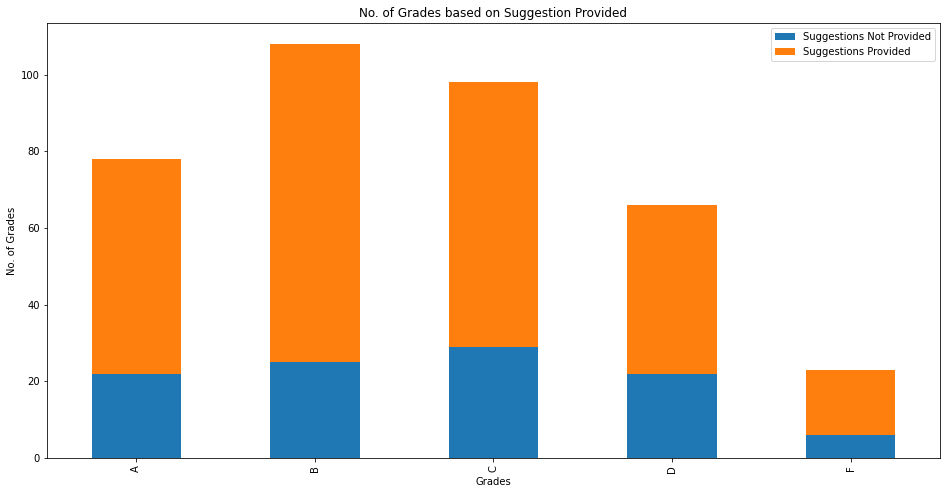

Number of Suggestions Not Provided (%): 27.882037533512065
Number of Suggestions Provided (%): 72.11796246648794



,Grades,Suggestions Not Provided,Suggestions Provided,Total,Suggestion %,No Suggestion %,Total %
0,A,22,56,78,0.150134,0.058981,0.209115
1,B,25,83,108,0.222520,0.067024,0.289544
2,C,29,69,98,0.184987,0.077748,0.262735
3,D,22,44,66,0.117962,0.058981,0.176944
4,F,6,17,23,0.045576,0.016086,0.061662


In [0]:
grade_df = cleaned_df[['grade','all_feedback']]
grade_df["suggestion_provided"] = 0
grade_df.loc[grade_df.all_feedback != '', 'suggestion_provided'] = 1
grade_status = grade_df.groupby(['grade','suggestion_provided']).size().reset_index(name='count')
grade_pivot = pd.pivot_table(grade_status, index=['grade'], columns=['suggestion_provided'],
                                       values='count', aggfunc=np.sum).reset_index()

grade_pivot.columns = ['Grades', 'Suggestions Not Provided', 'Suggestions Provided']
grade_pivot = grade_pivot.set_index('Grades')

fig, ax1 = plt.subplots()
grade_pivot.plot(kind='bar', stacked=True, 
                                  figsize=(16,8), title="No. of Grades based on Suggestion Provided",
                                   ax=ax1)
ax1.set_ylabel("No. of Grades")
plt.show()
suggestion_count = list(grade_df.groupby('suggestion_provided').size().reset_index(name='count')['count'])
print("Number of Suggestions Not Provided (%): {}\nNumber of Suggestions Provided (%): {}\n".format(suggestion_count[0]/sum(suggestion_count)*100,suggestion_count[1]/sum(suggestion_count)*100))
grade_pivot = grade_pivot.reset_index()
grade_pivot['Total'] = grade_pivot['Suggestions Not Provided'] + grade_pivot['Suggestions Provided']
grade_pivot['Suggestion %'] = grade_pivot['Suggestions Provided']/len(assignment_df)
grade_pivot['No Suggestion %'] = grade_pivot['Suggestions Not Provided']/len(assignment_df)
grade_pivot['Total %'] = grade_pivot['Total']/len(assignment_df)
display(grade_pivot)

##### Correlation

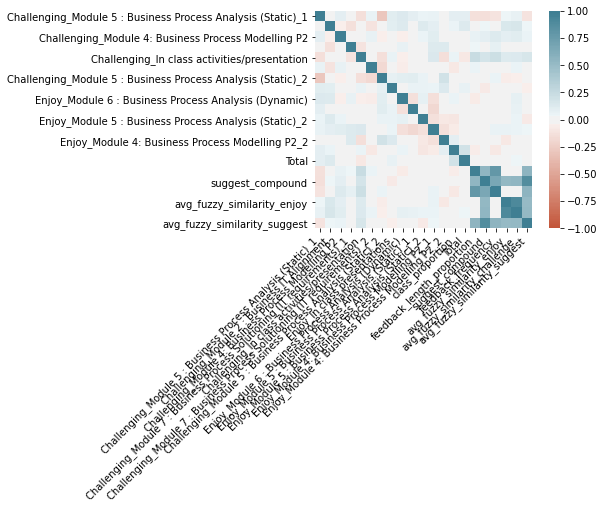

In [0]:
corr_df = cleaned_df.copy()
corr_df.drop('all_unclean_feedback', axis=1, inplace=True)
corr_df.drop('all_feedback', axis=1, inplace=True)
# corr_df.drop('Total',axis=1,inplace=True)
corr = corr_df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

##### EDA for Feedback Length Proportion

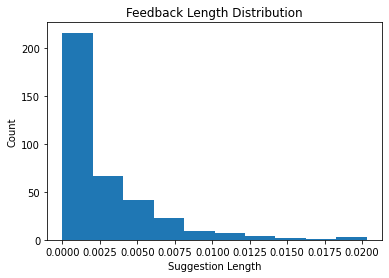

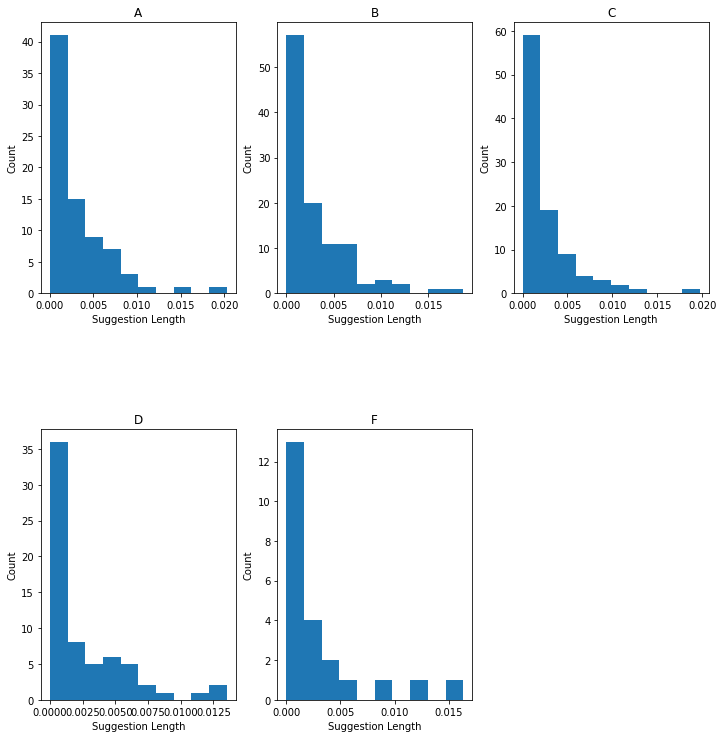

In [0]:
grades = ['A','B','C','D','F']
#Reason length feature
ax = cleaned_df['feedback_length_proportion'].plot(
    kind='hist',
    title='Feedback Length Distribution')
ax.set_xlabel("Suggestion Length")
ax.set_ylabel("Count")
plt.show()

ncols = 3
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
fig.tight_layout() 

fig.subplots_adjust(hspace=0.5)
# Lazy counter so we can remove unwated axes
counter = 0
for i in range(nrows):
    for j in range(ncols):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len(grades):

            ax.hist(cleaned_df['feedback_length_proportion'].loc[cleaned_df['grade']==grades[counter]])
            ax.set_xlabel("Suggestion Length")
            ax.set_ylabel("Count")
            title = ax.set_title("\n".join(wrap(str(grades[counter]), 20)))
            title.set_y(1)
        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1

plt.show()

##### EDA for Sentiment

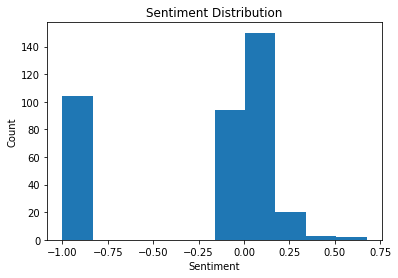

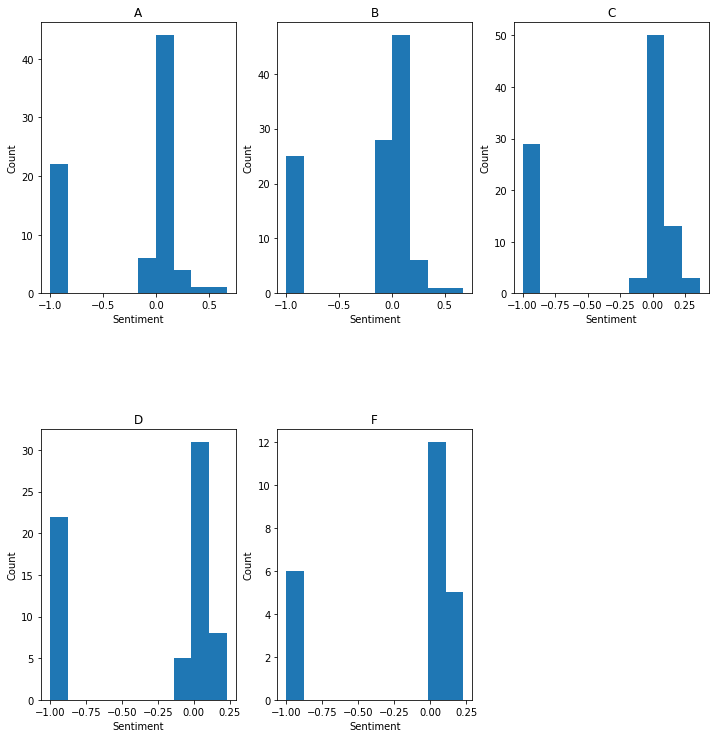

In [0]:
grades = ['A','B','C','D','F']
df = cleaned_df.copy()
df['suggest_compound'] -= 1
#Reason length feature
ax = df['suggest_compound'].plot(
    kind='hist',
    title='Sentiment Distribution')
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")
plt.show()

ncols = 3
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
fig.tight_layout() 

fig.subplots_adjust(hspace=0.5)
# Lazy counter so we can remove unwated axes
counter = 0
for i in range(nrows):
    for j in range(ncols):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len(grades):

            ax.hist(df['suggest_compound'].loc[df['grade']==grades[counter]])
            ax.set_xlabel("Sentiment")
            ax.set_ylabel("Count")
            title = ax.set_title("\n".join(wrap(str(grades[counter]), 20)))
            title.set_y(1)
        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1

plt.show()

##### EDA for Feedback Frequency

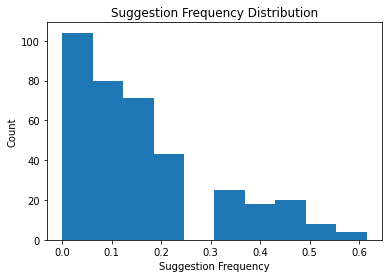

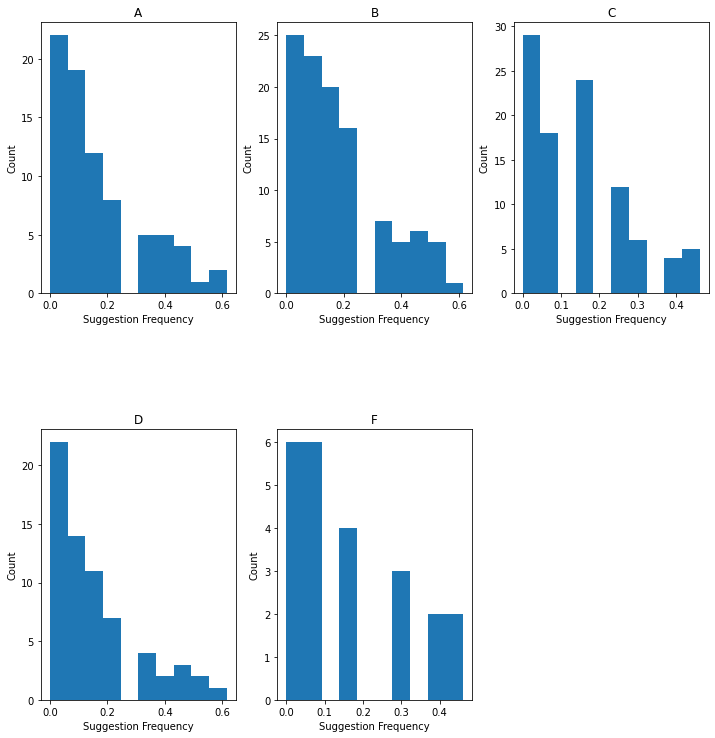

In [0]:
grades = ['A','B','C','D','F']
#Reason length feature
ax = cleaned_df['feedback_frequency'].plot(
    kind='hist',
    title='Suggestion Frequency Distribution')
ax.set_xlabel("Suggestion Frequency")
ax.set_ylabel("Count")
plt.show()

ncols = 3
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
fig.tight_layout() 

fig.subplots_adjust(hspace=0.5)
# Lazy counter so we can remove unwated axes
counter = 0
for i in range(nrows):
    for j in range(ncols):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len(grades):

            ax.hist(cleaned_df['feedback_frequency'].loc[cleaned_df['grade']==grades[counter]])
            ax.set_xlabel("Suggestion Frequency")
            ax.set_ylabel("Count")
            title = ax.set_title("\n".join(wrap(str(grades[counter]), 20)))
            title.set_y(1)
        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1

plt.show()

##### EDA for Class Distribution

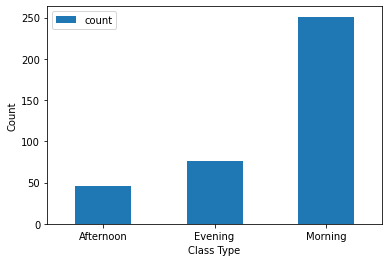

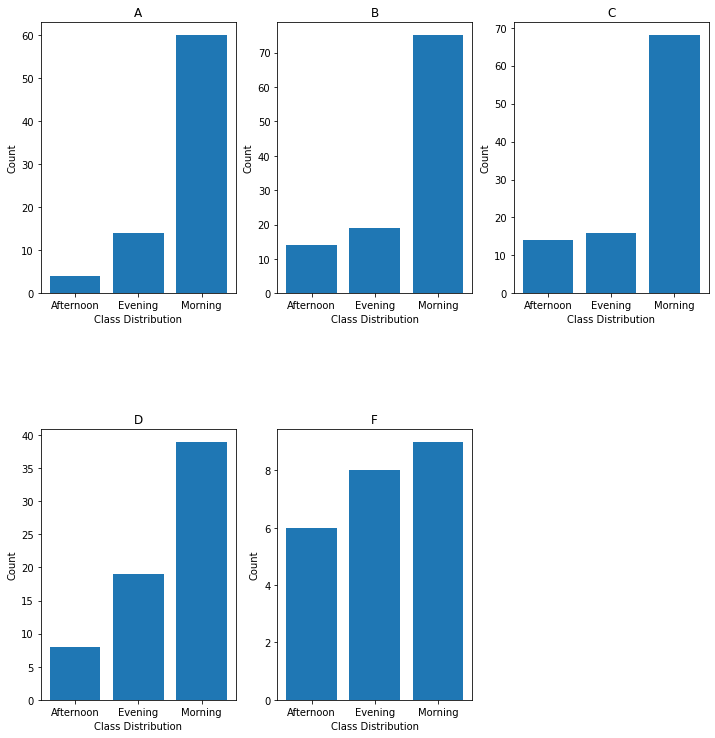

In [0]:
grades = ['A','B','C','D','F']
class_type_df = cleaned_df.groupby('Class Type').size().reset_index(name='count')
ax = class_type_df.plot.bar(x='Class Type', y='count', rot=0)
ax.set_xlabel("Class Type")
ax.set_ylabel("Count")
plt.show()

class_type_df = cleaned_df.groupby(['Class Type','grade']).size().reset_index(name='count')

ncols = 3
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
fig.tight_layout() 

fig.subplots_adjust(hspace=0.5)
# Lazy counter so we can remove unwated axes
counter = 0
for i in range(nrows):
    for j in range(ncols):

        ax = axes[i][j]

        # Plot when we have data
        if counter < len(grades):
            current_df = class_type_df[class_type_df['grade']== grades[counter]]
            ax.bar(current_df['Class Type'],current_df['count'])
            ax.set_xlabel("Class Distribution")
            ax.set_ylabel("Count")
            title = ax.set_title("\n".join(wrap(str(grades[counter]), 20)))
            title.set_y(1)
        # Remove axis when we no longer have data
        else:
            ax.set_axis_off()

        counter += 1
cleaned_df.drop('Class Type',axis=1,inplace=True)
plt.show()

##### EDA for Fuzzy Matching Similarity

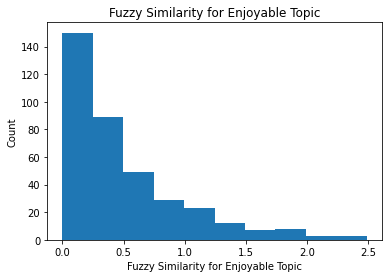

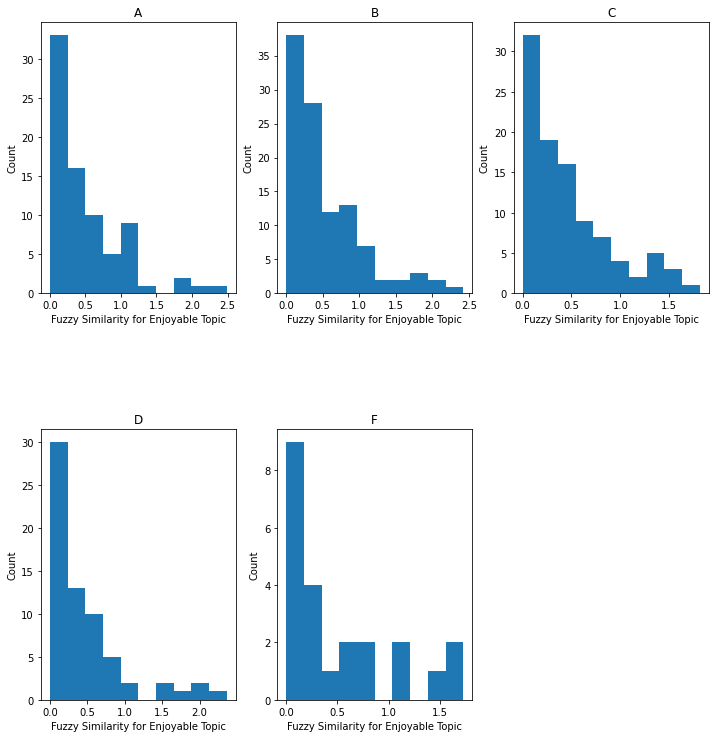

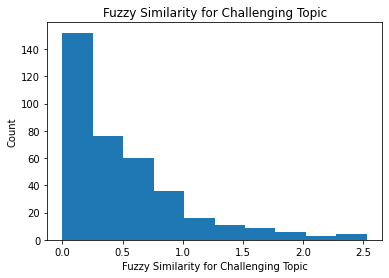

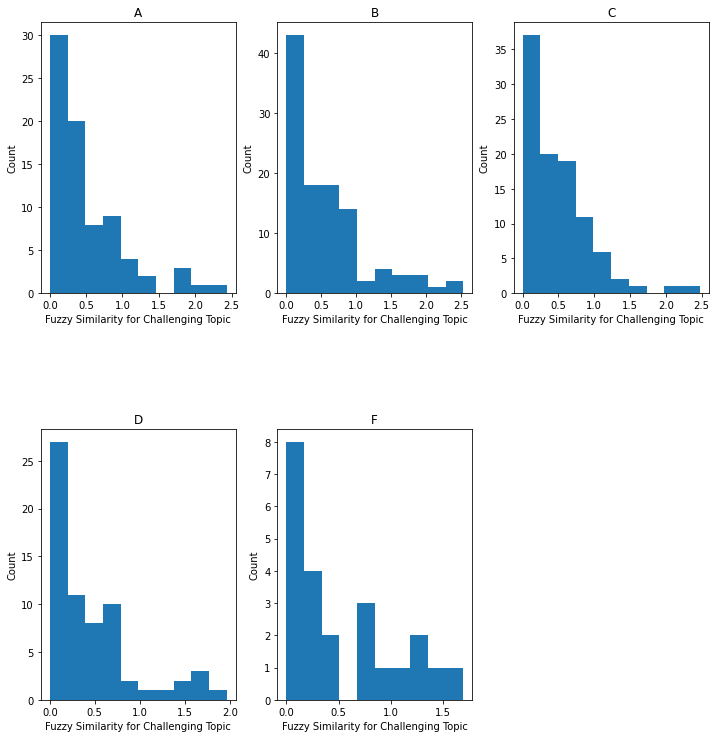

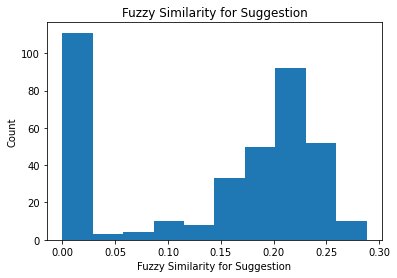

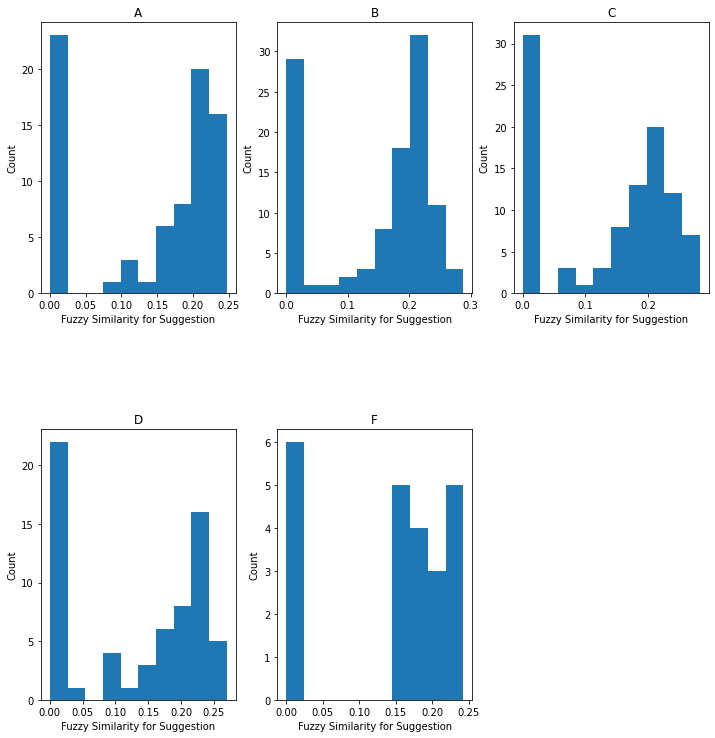

In [0]:
grades = ['A','B','C','D','F']
#Reason length feature
for column in ['avg_fuzzy_similarity_enjoy','avg_fuzzy_similarity_challenge','avg_fuzzy_similarity_suggest']:
    if 'enjoy' in column:
        chart_title = "Fuzzy Similarity for Enjoyable Topic"
    elif 'challenge' in column:
        chart_title = "Fuzzy Similarity for Challenging Topic"
    elif 'suggest' in column:
        chart_title = "Fuzzy Similarity for Suggestion"
    ax = cleaned_df[column].plot(
        kind='hist',
        title=chart_title)
    if 'enjoy' in column:
        ax.set_xlabel("Fuzzy Similarity for Enjoyable Topic")
    elif 'challenge' in column:
        ax.set_xlabel("Fuzzy Similarity for Challenging Topic")
    elif 'suggest' in column:
        ax.set_xlabel("Fuzzy Similarity for Suggestion")
    ax.set_ylabel("Count")
    plt.show()

    ncols = 3
    nrows = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    fig.tight_layout() 

    fig.subplots_adjust(hspace=0.5)
    # Lazy counter so we can remove unwated axes
    counter = 0
    
    for i in range(nrows):
        for j in range(ncols):

            ax = axes[i][j]

            # Plot when we have data
            if counter < len(grades):

                ax.hist(cleaned_df[column].loc[cleaned_df['grade']==grades[counter]])
                if 'enjoy' in column:
                     ax.set_xlabel("Fuzzy Similarity for Enjoyable Topic")
                elif 'challenge' in column:
                     ax.set_xlabel("Fuzzy Similarity for Challenging Topic")
                elif 'suggest' in column:
                     ax.set_xlabel("Fuzzy Similarity for Suggestion")
                ax.set_ylabel("Count")
                title = ax.set_title("\n".join(wrap(str(grades[counter]), 20)))
                title.set_y(1)
            # Remove axis when we no longer have data
            else:
                ax.set_axis_off()

            counter += 1
    plt.show()

##### EDA for Topic Modelling

{'Challenging_Module 5 : Business Process Analysis (Static)_1': 0, 'Challenging_Module 2 : Business IT Alignment': 1, 'Challenging_Module 4: Business Process Modelling P2': 2, 'Challenging_Module 7 : Business Process Solutioning (IT requirements)_1': 3, 'Challenging_In class activities/presentation': 4, 'Challenging_Module 7 : Business Process Solutioning (IT requirements)_2': 5, 'Challenging_Module 5 : Business Process Analysis (Static)_2': 6, 'Enjoy_In class presentations': 7, 'Enjoy_Module 6 : Business Process Analysis (Dynamic)': 8, 'Enjoy_Module 5 : Business Process Analysis (Static)_1': 9, 'Enjoy_Module 5 : Business Process Analysis (Static)_2': 10, 'Enjoy_Module 4: Business Process Modelling P2_1': 11, 'Enjoy_Module 4: Business Process Modelling P2_2': 12}


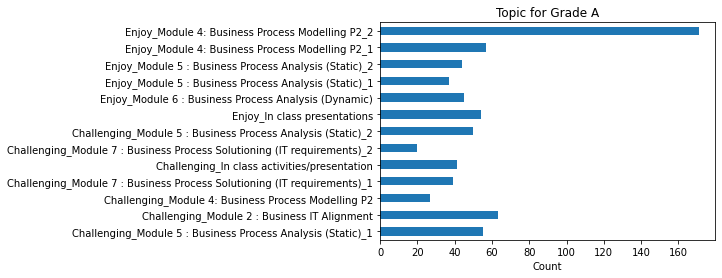

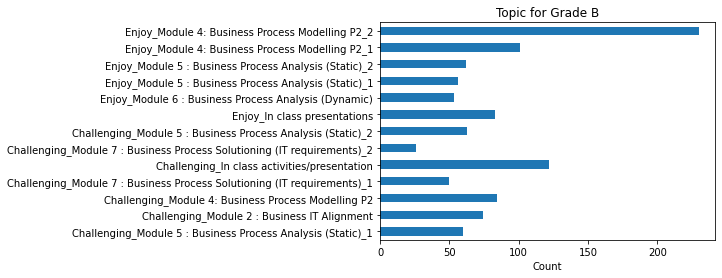

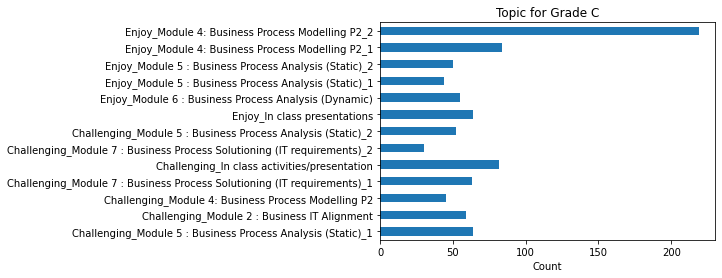

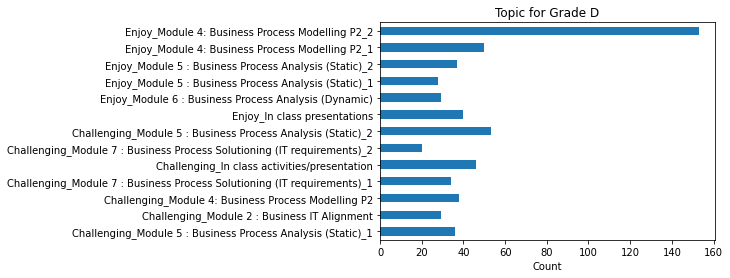

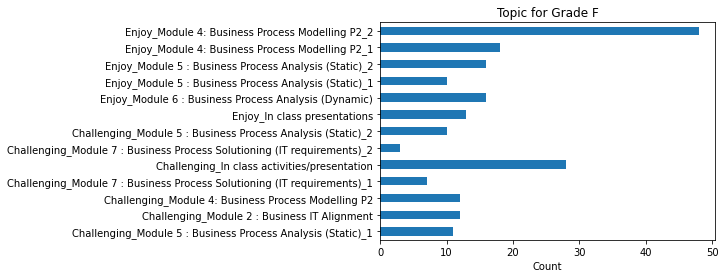

In [0]:
grades = ['A','B','C','D','F']

topic_df = cleaned_df[['grade','Challenging_Module 5 : Business Process Analysis (Static)_1','Challenging_Module 2 : Business IT Alignment',
               'Challenging_Module 4: Business Process Modelling P2','Challenging_Module 7 : Business Process Solutioning (IT requirements)_1',
               'Challenging_In class activities/presentation','Challenging_Module 7 : Business Process Solutioning (IT requirements)_2',
               'Challenging_Module 5 : Business Process Analysis (Static)_2','Enjoy_In class presentations','Enjoy_Module 6 : Business Process Analysis (Dynamic)',
               'Enjoy_Module 5 : Business Process Analysis (Static)_1','Enjoy_Module 5 : Business Process Analysis (Static)_2',
               'Enjoy_Module 4: Business Process Modelling P2_1','Enjoy_Module 4: Business Process Modelling P2_2']]

topic_dict = dict(enumerate(['Challenging_Module 5 : Business Process Analysis (Static)_1','Challenging_Module 2 : Business IT Alignment',
               'Challenging_Module 4: Business Process Modelling P2','Challenging_Module 7 : Business Process Solutioning (IT requirements)_1',
               'Challenging_In class activities/presentation','Challenging_Module 7 : Business Process Solutioning (IT requirements)_2',
               'Challenging_Module 5 : Business Process Analysis (Static)_2','Enjoy_In class presentations','Enjoy_Module 6 : Business Process Analysis (Dynamic)',
               'Enjoy_Module 5 : Business Process Analysis (Static)_1','Enjoy_Module 5 : Business Process Analysis (Static)_2',
               'Enjoy_Module 4: Business Process Modelling P2_1','Enjoy_Module 4: Business Process Modelling P2_2']))
topic_index = topic_dict.keys()
topics = topic_dict.values()
topic_dict = dict(zip(topics, topic_index))
grade_status = topic_df.groupby(['grade']).sum().reset_index()

print(topic_dict)
grade_status = grade_status.set_index('grade')
# grade_status = grade_status.rename(columns=topic_dict)
for index,row in grade_status.iterrows():
    fig, ax1 = plt.subplots()
    row.plot(kind='barh', stacked=True, title='Topic for Grade ' + str(index),
                                    ax=ax1)
    ax1.set_xlabel("Count")
    plt.show()

### Train Models

#### Defining Model Parameters

In [0]:
outer_kf = StratifiedKFold(n_splits=5,shuffle=False,random_state=0)
inner_kf = StratifiedKFold(n_splits=3,shuffle=False,random_state=0)
model_evaluation = {'Approach':[],'Best Features':[],'F1 Weighted':[],'F1 Micro':[],'Run Time':[]}

##### Prepare Dataframe for Model

In [0]:
model1_df = cleaned_df.copy()

##### Train Model

In [0]:
start = time.process_time()

classifiers = {
            "Multinomial Naive Bayes":MultinomialNB(),
            "SVM": svm.SVC(),
            "Random Forest": RandomForestClassifier(),
            'KNN':KNeighborsClassifier()
            }

best_baseline_weighted = 0
best_baseline_micro = 0
classifier_name = ''
run_time = 0

for name, classifier in classifiers.items():

    outer_loop_f1_micro_scores = []
    outer_loop_f1_weighted_scores = []
    X = model1_df['all_unclean_feedback']
    y = model1_df['grade']
    temp_X = X.values
    temp_y = y.values

    model_start = time.process_time()
    # Looping through the outer loop, feeding each training set into a GSCV as the inner loop
    for train_index,test_index in outer_kf.split(temp_X,temp_y):
        
        v = TfidfVectorizer (ngram_range = (1,2))
        X_train = list(X.iloc[train_index])
        X_test = list(X.iloc[test_index])
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        x_train = v.fit_transform(X_train)
        X_train = pd.DataFrame(x_train.toarray(), columns=v.get_feature_names())
        x_test = v.transform(X_test)
        X_test = pd.DataFrame(x_test.toarray(), columns=v.get_feature_names())
        
        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)
        
        classifier.fit(X_train,y_train)

        
        pred = classifier.predict(X_test)

        f1_micro = f1_score(y_test, pred,average='micro')
        f1_weighted = f1_score(y_test, pred,average='weighted')
        outer_loop_f1_micro_scores.append(f1_micro)
        outer_loop_f1_weighted_scores.append(f1_weighted)

    avg_f1_micro = np.mean(outer_loop_f1_micro_scores)
    avg_f1_weighted = np.mean(outer_loop_f1_weighted_scores)
    current_run_time = time.process_time() - model_start
    print('\033[1mCurrent Model: {}\033[0m'.format(name))
    print('Mean of outer loop f1 weighted score:',avg_f1_weighted)
    print('Mean of outer loop f1 micro score:',avg_f1_micro)
    print('Time taken:',current_run_time)
    print()
    if avg_f1_weighted > best_baseline_weighted:
        best_baseline_weighted = avg_f1_weighted
        best_baseline_micro = avg_f1_micro
        classifier_name = name
        run_time = current_run_time

model_evaluation['Approach'].append('Baseline (Raw Text)')
model_evaluation['Best Features'].append('')
model_evaluation['F1 Weighted'].append(best_baseline_weighted)
model_evaluation['F1 Micro'].append(best_baseline_micro)
model_evaluation['Run Time'].append(run_time)

print("\033[1mSelected Model: {}\033[0m".format(classifier_name))
print('Run Time: {} seconds'.format(str((time.process_time() - start))))

Current Model: Multinomial Naive Bayes
Mean of outer loop f1 weighted score: 0.18036887594713322
Mean of outer loop f1 micro score: 0.28670270270270265
Time taken: 2.2133939390000137

Current Model: SVM
Mean of outer loop f1 weighted score: 0.18327099758161222
Mean of outer loop f1 micro score: 0.27603603603603605
Time taken: 6.971420519999981

Current Model: Random Forest
Mean of outer loop f1 weighted score: 0.20181423957307723
Mean of outer loop f1 micro score: 0.24929729729729727
Time taken: 3.6743813779999925

Current Model: KNN
Mean of outer loop f1 weighted score: 0.23256944280396538
Mean of outer loop f1 micro score: 0.27372972972972975
Time taken: 1.8452213390000054

Selected Model: KNN
Run Time: 14.711758783999983 seconds


##### EDA for Words in Grades 

A


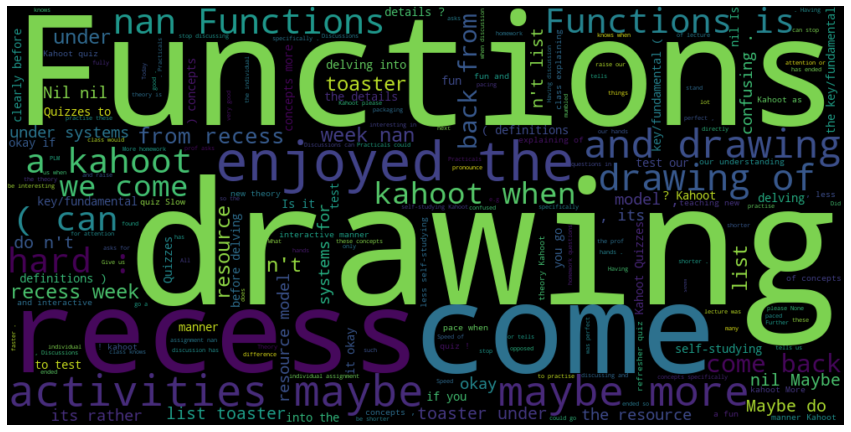

B


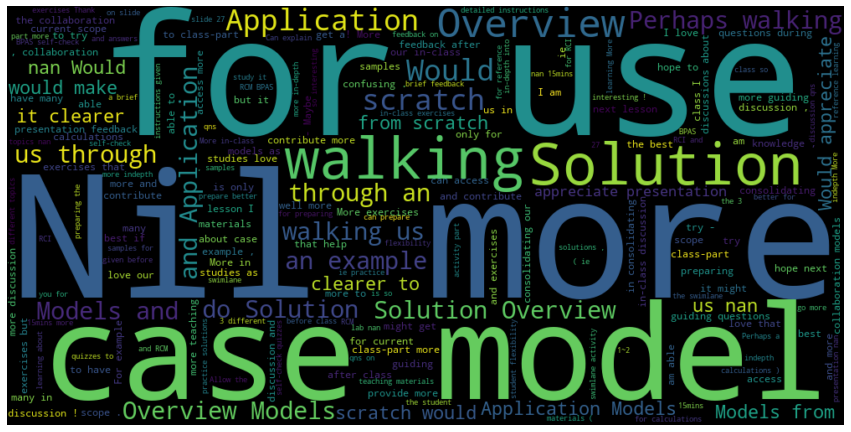

C


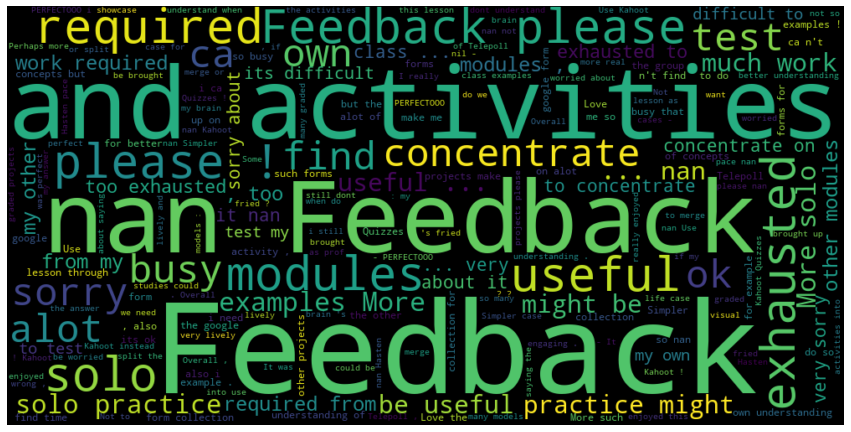

D


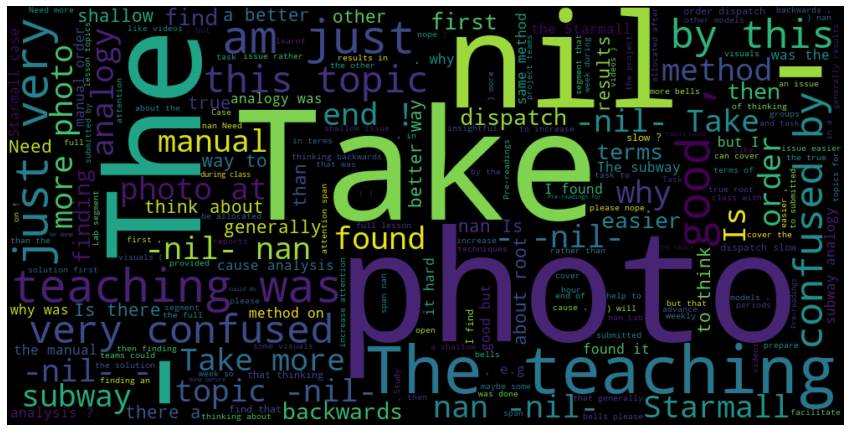

F


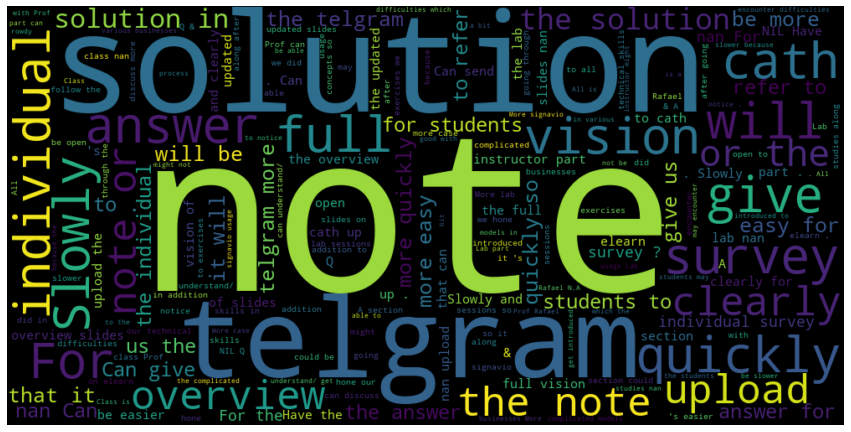

In [0]:
grades = ['A','B','C','D','F']

characteristic_words = []
for grade in grades:
    print(grade)
    suggestion = [nltk.word_tokenize(text) for text in cleaned_df[cleaned_df['grade']==grade]['all_unclean_feedback']]

    words = []

    for text in suggestion:
        for i in range(1,3):
            grams = ngrams(text, i)

            for gram in grams:
                words.append(' '.join(gram))
                
    counter = Counter()
    counter.update(words)
    median = (np.median([x for x in counter.values()]))
    least_common = {}
    for word,value in counter.items():
        if value <= median:
            least_common[word] = value
            if word not in characteristic_words:
                characteristic_words.append(word)
    # print(least_common)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(dict(least_common))
    # Display the generated image:
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# characteristic_words = clean_text(characteristic_words)
# print(characteristic_words)
# print(len(characteristic_words))

#### Train Model with All Words & All Features Combination

##### Prepare Dataframe for Model

In [0]:
model1_df = cleaned_df.copy()

columns = ['class_proportion', 'feedback_length_proportion','suggest_compound','feedback_frequency',
           'similarity','topic']

similarity_columns = ['avg_fuzzy_similarity_enjoy','avg_fuzzy_similarity_challenge','avg_fuzzy_similarity_suggest']

topic_column = ['Challenging_Module 5 : Business Process Analysis (Static)_1','Challenging_Module 2 : Business IT Alignment',
               'Challenging_Module 4: Business Process Modelling P2','Challenging_Module 7 : Business Process Solutioning (IT requirements)_1',
               'Challenging_In class activities/presentation','Challenging_Module 7 : Business Process Solutioning (IT requirements)_2',
               'Challenging_Module 5 : Business Process Analysis (Static)_2','Enjoy_In class presentations','Enjoy_Module 6 : Business Process Analysis (Dynamic)',
               'Enjoy_Module 5 : Business Process Analysis (Static)_1','Enjoy_Module 5 : Business Process Analysis (Static)_2',
               'Enjoy_Module 4: Business Process Modelling P2_1','Enjoy_Module 4: Business Process Modelling P2_2']

combinations = []
default_list = ['all_feedback']
default_list.sort()
# combinations.append(default_list)
for L in range(0, len(columns)+1):
        for subset in itertools.permutations(columns, L):
            subset = list(subset)
            subset.sort()
            if subset != [] and subset not in combinations:
                combinations.append(subset)

for i in range(len(combinations)):
    combinations[i] += default_list
    combinations[i].sort()
    if 'similarity' in combinations[i]:
        combinations[i].remove('similarity')
        combinations[i] += similarity_columns
    if 'topic' in combinations[i]:
        combinations[i].remove('topic')
        combinations[i] += topic_column
    # print(combinations[i])
combinations.insert(0, default_list)

print(combinations)
print(len(combinations))

[['all_feedback'], ['all_feedback', 'class_proportion'], ['all_feedback', 'feedback_length_proportion'], ['all_feedback', 'suggest_compound'], ['all_feedback', 'feedback_frequency'], ['all_feedback', 'avg_fuzzy_similarity_enjoy', 'avg_fuzzy_similarity_challenge', 'avg_fuzzy_similarity_suggest'], ['all_feedback', 'Challenging_Module 5 : Business Process Analysis (Static)_1', 'Challenging_Module 2 : Business IT Alignment', 'Challenging_Module 4: Business Process Modelling P2', 'Challenging_Module 7 : Business Process Solutioning (IT requirements)_1', 'Challenging_In class activities/presentation', 'Challenging_Module 7 : Business Process Solutioning (IT requirements)_2', 'Challenging_Module 5 : Business Process Analysis (Static)_2', 'Enjoy_In class presentations', 'Enjoy_Module 6 : Business Process Analysis (Dynamic)', 'Enjoy_Module 5 : Business Process Analysis (Static)_1', 'Enjoy_Module 5 : Business Process Analysis (Static)_2', 'Enjoy_Module 4: Business Process Modelling P2_1', 'Enjoy

##### Train Model

In [0]:
start = time.process_time()

all_words_best_features = []
all_words_weighted = 0
all_words_micro = 0
all_words_run_time = 0

evaluation = {'Best Features':[],'F1 Weighted':[],'F1 Micro':[],'Run Time':[]}

for i in range(len(combinations)):
    combination = combinations[i]
    features = ' + '.join(combination)
    
    print('\033[1m{}) Current Features: {}\033[0m'.format(i+1,features))

    classifiers = {
            "Multinomial Naive Bayes":MultinomialNB(),
            "SVM": svm.SVC(),
            "Random Forest": RandomForestClassifier(),
            'KNN':KNeighborsClassifier()
            }

    params = {
            "Multinomial Naive Bayes":{"alpha": [0.01, 0.03, 0.1, 0.3, 1, 3, 10],'fit_prior':[True,False]},
            "SVM": {"C":[0.01, 0.03, 0.1, 0.3, 1, 3, 10], "gamma":[0.01, 0.03, 0.1, 0.3, 1, 3, 10],'kernel':['linear', 'poly', 'rbf']},
            "Random Forest": { 'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2',None], 'max_depth' : [3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150,None],  'criterion' :['gini', 'entropy']},
            'KNN': {'weights':['uniform','distance'],'metric':['euclidean','manhattan','minkowski'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}
            }

    outer_loop_f1_micro_scores = []
    outer_loop_f1_weighted_scores = []
    inner_loop_won_params = []
    inner_loop_f1_weighted_scores = []

    model = classifiers[classifier_name]
    model_param_grid = params[classifier_name]

    
    X = model1_df[combination]
    y = model1_df['grade']
    temp_X = X.values
    temp_y = y.values

    model_start = time.process_time()

    # Looping through the outer loop, feeding each training set into a GSCV as the inner loop
    for train_index,test_index in outer_kf.split(temp_X,temp_y):

        v = TfidfVectorizer (ngram_range = (1,2))
        
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]

        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
    
        v.fit(X_train['all_feedback'])

        x_train_tfidf = v.transform(X_train['all_feedback'])
        x_test_tfidf = v.transform(X_test['all_feedback'])

        X_train_word = pd.DataFrame(x_train_tfidf.toarray(), columns=v.get_feature_names())
        X_test_word = pd.DataFrame(x_test_tfidf.toarray(), columns=v.get_feature_names())

        X_train = X_train.merge(X_train_word, left_index=True, right_index=True,how='left')
        X_test = X_test.merge(X_test_word, left_index=True, right_index=True,how='left')
        
        X_train.drop('all_feedback', axis=1, inplace=True)
        X_test.drop('all_feedback', axis=1, inplace=True)

        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)
        
        RSCV = RandomizedSearchCV(estimator=model,param_distributions=model_param_grid,cv=inner_kf,scoring='f1_weighted')
        
        # GSCV is looping through the training data to find the best parameters. This is the inner loop
        RSCV.fit(X_train,y_train)

        # # The best hyper parameters from GSCV is now being tested on the unseen outer loop test data.
        pred = RSCV.predict(X_test)

        # # Appending the "winning" hyper parameters and their associated accuracy score
        inner_loop_won_params.append(RSCV.best_params_)
        inner_loop_f1_weighted_scores.append(RSCV.best_score_)
        outer_loop_f1_micro_scores.append(f1_score(y_test, pred,average='micro'))
        outer_loop_f1_weighted_scores.append(f1_score(y_test, pred,average='weighted'))

    print('Inner Won Params, Outer Loop F1 Weighted, Inner Loop F1 Weighted')
    for i in zip(inner_loop_won_params,outer_loop_f1_weighted_scores,inner_loop_f1_weighted_scores):
        print(i)

    avg_f1_micro = np.mean(outer_loop_f1_micro_scores)
    avg_f1_weighted = np.mean(outer_loop_f1_weighted_scores)
    current_run_time = time.process_time() - model_start
    evaluation['Best Features'].append(features)
    evaluation['F1 Weighted'].append(avg_f1_weighted)
    evaluation['F1 Micro'].append(avg_f1_micro)
    evaluation['Run Time'].append(current_run_time)
    print('Mean of outer loop f1 weighted score:',avg_f1_weighted)
    print('Mean of outer loop f1 micro score:',avg_f1_micro)
    print('Time taken: {} seconds'.format(current_run_time))
    print()
    if avg_f1_weighted > all_words_weighted:
        all_words_weighted = avg_f1_weighted
        all_words_micro = avg_f1_micro
        all_words_best_features = features
        all_words_run_time = current_run_time

model_evaluation['Approach'].append('All Words (Cleaned Text)')
model_evaluation['Best Features'].append(all_words_best_features)
model_evaluation['F1 Weighted'].append(all_words_weighted)
model_evaluation['F1 Micro'].append(all_words_micro)
model_evaluation['Run Time'].append(all_words_run_time)

model_df = pd.DataFrame.from_dict(evaluation)
model_df.style.set_properties(subset=['Best Features'], **{'width': '600px'})
model_df.to_csv('evaluation (all words).csv',index=False)

print("\033[1m{} works best with {}.\033[0m".format(classifier_name,all_words_best_features))
print('F1 Weighted: {}'.format(all_words_weighted))
print('F1 Micro: {}'.format(all_words_micro))
print('Run Time: {} seconds'.format(str((time.process_time() - start))))

1) Current Features: all_feedback
Inner Won Params, Outer Loop F1 Weighted, Inner Loop F1 Weighted
({'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'kd_tree'}, 0.16435489572287026, 0.1339436067071891)
({'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'ball_tree'}, 0.1283333333333333, 0.1309942906968279)
({'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'auto'}, 0.07501831501831502, 0.1331169350798084)
({'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'kd_tree'}, 0.12546230440967282, 0.20648832847050458)
({'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'ball_tree'}, 0.06832675372001215, 0.18550407669201874)
Mean of outer loop f1 weighted score: 0.11229912044084071
Mean of outer loop f1 micro score: 0.24929729729729727
Time taken: 34.82334001199999 seconds

2) Current Features: all_feedback + class_proportion
Inner Won Params, Outer Loop F1 Weighted, Inner Loop F1 Weighted
({'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 

#### Train Model with Words which Occurs More than Median of Training Dataset & All Features Combination

##### Prepare Dataframe for Model

In [0]:
model1_df = cleaned_df.copy()

columns = ['class_proportion', 'feedback_length_proportion','suggest_compound','feedback_frequency',
           'similarity','topic']

similarity_columns = ['avg_fuzzy_similarity_enjoy','avg_fuzzy_similarity_challenge','avg_fuzzy_similarity_suggest']

topic_column = ['Challenging_Module 5 : Business Process Analysis (Static)_1','Challenging_Module 2 : Business IT Alignment',
               'Challenging_Module 4: Business Process Modelling P2','Challenging_Module 7 : Business Process Solutioning (IT requirements)_1',
               'Challenging_In class activities/presentation','Challenging_Module 7 : Business Process Solutioning (IT requirements)_2',
               'Challenging_Module 5 : Business Process Analysis (Static)_2','Enjoy_In class presentations','Enjoy_Module 6 : Business Process Analysis (Dynamic)',
               'Enjoy_Module 5 : Business Process Analysis (Static)_1','Enjoy_Module 5 : Business Process Analysis (Static)_2',
               'Enjoy_Module 4: Business Process Modelling P2_1','Enjoy_Module 4: Business Process Modelling P2_2']

combinations = []

default_list = ['all_feedback']
default_list.sort()
# combinations.append(default_list)
for L in range(0, len(columns)+1):
        for subset in itertools.permutations(columns, L):
            subset = list(subset)
            subset.sort()
            if subset != [] and subset not in combinations:
                combinations.append(subset)

for i in range(len(combinations)):
    combinations[i] += default_list
    combinations[i].sort()
    if 'similarity' in combinations[i]:
        combinations[i].remove('similarity')
        combinations[i] += similarity_columns
    if 'topic' in combinations[i]:
        combinations[i].remove('topic')
        combinations[i] += topic_column
combinations.insert(0, default_list)
print(len(combinations))

64


##### Train Model

In [0]:
start = time.process_time()

frequent_words_best_features = []
frequent_words_best_weighted = 0
frequent_words_best_micro = 0
frequent_words_run_time = 0

evaluation = {'Best Features':[],'F1 Weighted':[],'F1 Micro':[],'Run Time':[]}

for i in range(len(combinations)):
    combination = combinations[i]
    features = ' + '.join(combination)
    
    print('\033[1m{}) Current Features: {}\033[0m'.format(i+1,features))

    classifiers = {
            "Multinomial Naive Bayes":MultinomialNB(),
            "SVM": svm.SVC(),
            "Random Forest": RandomForestClassifier(),
            'KNN':KNeighborsClassifier()
            }

    params = {
            "Multinomial Naive Bayes":{"alpha": [0.01, 0.03, 0.1, 0.3, 1, 3, 10],'fit_prior':[True,False]},
            "SVM": {"C":[0.01, 0.03, 0.1, 0.3, 1, 3, 10], "gamma":[0.01, 0.03, 0.1, 0.3, 1, 3, 10],'kernel':['linear', 'poly', 'rbf']},
            "Random Forest": { 'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2',None], 'max_depth' : [3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150,None],  'criterion' :['gini', 'entropy']},
            'KNN': {'weights':['uniform','distance'],'metric':['euclidean','manhattan','minkowski'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}
            }

    model_start = time.process_time()

    outer_loop_f1_micro_scores = []
    outer_loop_f1_weighted_scores = []
    inner_loop_won_params = []
    inner_loop_f1_weighted_scores = []

    model = classifiers[classifier_name]
    model_param_grid = params[classifier_name]

    
    X = model1_df[combination]
    y = model1_df['grade']
    temp_X = X.values
    temp_y = y.values

    # Looping through the outer loop, feeding each training set into a GSCV as the inner loop
    for train_index,test_index in outer_kf.split(temp_X,temp_y):
                            
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]

        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        v = CountVectorizer (ngram_range = (1,2))
        x = v.fit_transform(X_train['all_feedback'])

        df = pd.DataFrame(x.toarray(), columns=v.get_feature_names())
        word_df = df.sum().reset_index(name='count').rename(columns={"index": "word", "count": "count"})
        word_df = word_df.sort_values(by='count',ascending = False).reset_index()
        word_df = word_df.drop(columns='index')
        median = word_df['count'].median() 
        relevant_words = list(word_df[word_df['count'] > median]['word'])

        v = TfidfVectorizer (ngram_range = (1,2),vocabulary=relevant_words)
        v.fit(X_train['all_feedback'])

        x_train_tfidf = v.transform(X_train['all_feedback'])
        x_test_tfidf = v.transform(X_test['all_feedback'])

        X_train_word = pd.DataFrame(x_train_tfidf.toarray(), columns=v.get_feature_names())
        X_test_word = pd.DataFrame(x_test_tfidf.toarray(), columns=v.get_feature_names())

        X_train = X_train.merge(X_train_word, left_index=True, right_index=True,how='left')
        X_test = X_test.merge(X_test_word, left_index=True, right_index=True,how='left')
        
        X_train.drop('all_feedback', axis=1, inplace=True)
        X_test.drop('all_feedback', axis=1, inplace=True)

        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)
        
        RSCV = RandomizedSearchCV(estimator=model,param_distributions=model_param_grid,cv=inner_kf,scoring='f1_weighted')
        
        # GSCV is looping through the training data to find the best parameters. This is the inner loop
        RSCV.fit(X_train,y_train)

        # # The best hyper parameters from GSCV is now being tested on the unseen outer loop test data.
        pred = RSCV.predict(X_test)

        # # Appending the "winning" hyper parameters and their associated accuracy score
        inner_loop_won_params.append(RSCV.best_params_)
        inner_loop_f1_weighted_scores.append(RSCV.best_score_)
        outer_loop_f1_micro_scores.append(f1_score(y_test, pred,average='micro'))
        outer_loop_f1_weighted_scores.append(f1_score(y_test, pred,average='weighted'))

    print('Inner Won Params, Outer Loop F1 Weighted, Inner Loop F1 Weighted')
    for i in zip(inner_loop_won_params,outer_loop_f1_weighted_scores,inner_loop_f1_weighted_scores):
        print(i)

    avg_f1_micro = np.mean(outer_loop_f1_micro_scores)
    avg_f1_weighted = np.mean(outer_loop_f1_weighted_scores)
    current_run_time = time.process_time() - model_start
    print('Mean of outer loop f1 weighted score:',avg_f1_weighted)
    print('Mean of outer loop f1 micro score:',avg_f1_micro)
    print('Time taken: {} seconds'.format(current_run_time))
    print()
    evaluation['Best Features'].append(features)
    evaluation['F1 Weighted'].append(avg_f1_weighted)
    evaluation['F1 Micro'].append(avg_f1_micro)
    evaluation['Run Time'].append(current_run_time)
    if avg_f1_weighted > frequent_words_best_weighted:
        frequent_words_best_weighted = avg_f1_weighted
        frequent_words_best_micro = avg_f1_micro
        frequent_words_best_features = features
        frequent_words_run_time = current_run_time

model_evaluation['Approach'].append('Words that occur more than median of training dataset (Cleaned Text)')
model_evaluation['Best Features'].append(frequent_words_best_features)
model_evaluation['F1 Weighted'].append(frequent_words_best_weighted)
model_evaluation['F1 Micro'].append(frequent_words_best_micro)
model_evaluation['Run Time'].append(frequent_words_run_time)

model_df = pd.DataFrame.from_dict(evaluation)
model_df.style.set_properties(subset=['Best Features'], **{'width': '600px'})
model_df.to_csv('evaluation (frequent words).csv',index=False)

print("\033[1m{} works best with {}.\033[0m".format(classifier_name,frequent_words_best_features))
print('F1 Weighted: {}'.format(frequent_words_best_weighted))
print('F1 Micro: {}'.format(frequent_words_best_micro))
print('Run Time: {} seconds'.format(str((time.process_time() - start))))

1) Current Features: all_feedback
Inner Won Params, Outer Loop F1 Weighted, Inner Loop F1 Weighted
({'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'auto'}, 0.14905982905982906, 0.12629767359151797)
({'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'ball_tree'}, 0.12482269503546102, 0.18286918739202926)
({'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'kd_tree'}, 0.13305841924398623, 0.16072801837316425)
({'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'auto'}, 0.12546230440967282, 0.2027806629258113)
({'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'kd_tree'}, 0.06832675372001215, 0.2208696066454485)
Mean of outer loop f1 weighted score: 0.12014600029379226
Mean of outer loop f1 micro score: 0.2572972972972972
Time taken: 11.64420975100029 seconds

2) Current Features: all_feedback + class_proportion
Inner Won Params, Outer Loop F1 Weighted, Inner Loop F1 Weighted
({'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'auto

#### Train Model with Words which Occurs Less than or Equals to Training Dataset & All Features Combination

##### Prepare Dataframe for Model

In [0]:
columns = ['class_proportion', 'feedback_length_proportion','suggest_compound','feedback_frequency',
           'similarity','topic']

similarity_columns = ['avg_fuzzy_similarity_enjoy','avg_fuzzy_similarity_challenge','avg_fuzzy_similarity_suggest']

topic_column = ['Challenging_Module 5 : Business Process Analysis (Static)_1','Challenging_Module 2 : Business IT Alignment',
               'Challenging_Module 4: Business Process Modelling P2','Challenging_Module 7 : Business Process Solutioning (IT requirements)_1',
               'Challenging_In class activities/presentation','Challenging_Module 7 : Business Process Solutioning (IT requirements)_2',
               'Challenging_Module 5 : Business Process Analysis (Static)_2','Enjoy_In class presentations','Enjoy_Module 6 : Business Process Analysis (Dynamic)',
               'Enjoy_Module 5 : Business Process Analysis (Static)_1','Enjoy_Module 5 : Business Process Analysis (Static)_2',
               'Enjoy_Module 4: Business Process Modelling P2_1','Enjoy_Module 4: Business Process Modelling P2_2']

combinations = []

default_list = ['all_feedback']
default_list.sort()
# combinations.append(default_list)
for L in range(0, len(columns)+1):
        for subset in itertools.permutations(columns, L):
            subset = list(subset)
            subset.sort()
            if subset != [] and subset not in combinations:
                combinations.append(subset)

for i in range(len(combinations)):
    combinations[i] += default_list
    combinations[i].sort()
    if 'similarity' in combinations[i]:
        combinations[i].remove('similarity')
        combinations[i] += similarity_columns
    if 'topic' in combinations[i]:
        combinations[i].remove('topic')
        combinations[i] += topic_column
combinations.insert(0, default_list)

##### Train Model

In [0]:
start = time.process_time()

rare_words_best_features = []
rare_words_best_weighted = 0
rare_words_best_micro = 0
rare_words_run_time = 0

evaluation = {'Best Features':[],'F1 Weighted':[],'F1 Micro':[],'Run Time':[]}

for i in range(len(combinations)):
    combination = combinations[i]
    features = ' + '.join(combination)
    
    print('\033[1m{}) Current Features: {}\033[0m'.format(i+1,features))

    classifiers = {
            "Multinomial Naive Bayes":MultinomialNB(),
            "SVM": svm.SVC(),
            "Random Forest": RandomForestClassifier(),
            'KNN':KNeighborsClassifier()
            }

    params = {
            "Multinomial Naive Bayes":{"alpha": [0.01, 0.03, 0.1, 0.3, 1, 3, 10],'fit_prior':[True,False]},
            "SVM": {"C":[0.01, 0.03, 0.1, 0.3, 1, 3, 10], "gamma":[0.01, 0.03, 0.1, 0.3, 1, 3, 10],'kernel':['linear', 'poly', 'rbf']},
            "Random Forest": { 'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2',None], 'max_depth' : [3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150,None],  'criterion' :['gini', 'entropy']},
            'KNN': {'weights':['uniform','distance'],'metric':['euclidean','manhattan','minkowski'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}
            }

    outer_loop_f1_micro_scores = []
    outer_loop_f1_weighted_scores = []
    inner_loop_won_params = []
    inner_loop_f1_weighted_scores = []

    model = classifiers[classifier_name]
    model_param_grid = params[classifier_name]

    model_start = time.process_time()

    X = model1_df[combination]
    y = model1_df['grade']
    temp_X = X.values
    temp_y = y.values

    # Looping through the outer loop, feeding each training set into a GSCV as the inner loop
    for train_index,test_index in outer_kf.split(temp_X,temp_y):

              
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]

        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        v = CountVectorizer (ngram_range = (1,2))
        x = v.fit_transform(X_train['all_feedback'])

        df = pd.DataFrame(x.toarray(), columns=v.get_feature_names())
        word_df = df.sum().reset_index(name='count').rename(columns={"index": "word", "count": "count"})
        word_df = word_df.sort_values(by='count',ascending = False).reset_index()
        word_df = word_df.drop(columns='index')
        median = word_df['count'].median() 
        relevant_words = list(word_df[word_df['count'] <= median]['word'])

        v = TfidfVectorizer (ngram_range = (1,2),vocabulary=relevant_words)
        v.fit(X_train['all_feedback'])

        x_train_tfidf = v.transform(X_train['all_feedback'])
        x_test_tfidf = v.transform(X_test['all_feedback'])

        X_train_word = pd.DataFrame(x_train_tfidf.toarray(), columns=v.get_feature_names())
        X_test_word = pd.DataFrame(x_test_tfidf.toarray(), columns=v.get_feature_names())

        X_train = X_train.merge(X_train_word, left_index=True, right_index=True,how='left')
        X_test = X_test.merge(X_test_word, left_index=True, right_index=True,how='left')
        
        X_train.drop('all_feedback', axis=1, inplace=True)
        X_test.drop('all_feedback', axis=1, inplace=True)

        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)
        
        RSCV = RandomizedSearchCV(estimator=model,param_distributions=model_param_grid,cv=inner_kf,scoring='f1_weighted')
        
        # GSCV is looping through the training data to find the best parameters. This is the inner loop
        RSCV.fit(X_train,y_train)

        # # The best hyper parameters from GSCV is now being tested on the unseen outer loop test data.
        pred = RSCV.predict(X_test)

        # # Appending the "winning" hyper parameters and their associated accuracy score
        inner_loop_won_params.append(RSCV.best_params_)
        inner_loop_f1_weighted_scores.append(RSCV.best_score_)
        outer_loop_f1_micro_scores.append(f1_score(y_test, pred,average='micro'))
        outer_loop_f1_weighted_scores.append(f1_score(y_test, pred,average='weighted'))

    print('Inner Won Params, Outer Loop F1 Weighted, Inner Loop F1 Weighted')
    for i in zip(inner_loop_won_params,outer_loop_f1_weighted_scores,inner_loop_f1_weighted_scores):
        print(i)

    avg_f1_micro = np.mean(outer_loop_f1_micro_scores)
    avg_f1_weighted = np.mean(outer_loop_f1_weighted_scores)
    current_run_time = time.process_time() - model_start
    print('Mean of outer loop f1 weighted score:',avg_f1_weighted)
    print('Mean of outer loop f1 micro score:',avg_f1_micro)
    print('Time taken: {} seconds'.format(current_run_time))
    print()
    evaluation['Best Features'].append(features)
    evaluation['F1 Weighted'].append(avg_f1_weighted)
    evaluation['F1 Micro'].append(avg_f1_micro)
    evaluation['Run Time'].append(current_run_time)
    if avg_f1_weighted > rare_words_best_weighted:
        rare_words_best_weighted = avg_f1_weighted
        rare_words_best_micro = avg_f1_micro
        rare_words_best_features = features
        rare_words_run_time = current_run_time

model_evaluation['Approach'].append('Words that occur less than or equal to median of training dataset (Cleaned Text)')
model_evaluation['Best Features'].append(rare_words_best_features)
model_evaluation['F1 Weighted'].append(rare_words_best_weighted)
model_evaluation['F1 Micro'].append(rare_words_best_micro)
model_evaluation['Run Time'].append(rare_words_run_time)

model_df = pd.DataFrame.from_dict(evaluation)
model_df.style.set_properties(subset=['Best Features'], **{'width': '600px'})
model_df.to_csv('evaluation (rare words).csv',index=False)

print("\033[1m{} works best with {}.\033[0m".format(classifier_name,rare_words_best_features))
print('F1 Weighted: {}'.format(rare_words_best_weighted))
print('F1 Micro: {}'.format(rare_words_best_micro))
print('Run Time: {} seconds'.format(str((time.process_time() - start))))

1) Current Features: all_feedback
Inner Won Params, Outer Loop F1 Weighted, Inner Loop F1 Weighted
({'weights': 'uniform', 'metric': 'manhattan', 'algorithm': 'brute'}, 0.13305841924398623, 0.11629754913475844)
({'weights': 'distance', 'metric': 'euclidean', 'algorithm': 'ball_tree'}, 0.13391304347826086, 0.16658403234583077)
({'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'ball_tree'}, 0.13305841924398623, 0.11419115825119763)
({'weights': 'uniform', 'metric': 'minkowski', 'algorithm': 'ball_tree'}, 0.12546230440967282, 0.1387465348756102)
({'weights': 'distance', 'metric': 'minkowski', 'algorithm': 'ball_tree'}, 0.12546230440967282, 0.11820611445249125)
Mean of outer loop f1 weighted score: 0.13019089815711576
Mean of outer loop f1 micro score: 0.28684684684684686
Time taken: 26.542916333999983 seconds

2) Current Features: all_feedback + class_proportion
Inner Won Params, Outer Loop F1 Weighted, Inner Loop F1 Weighted
({'weights': 'uniform', 'metric': 'minkowski', 'algor

#### Evaluation of Model Performance across Perfomance

In [0]:
model_df = pd.DataFrame.from_dict(model_evaluation)
model_df.style.set_properties(subset=['Best Features'], **{'width': '600px'})
display(model_df)
model_df.to_csv('model_evaluation.csv',index=False)

,Approach,Best Features,F1 Weighted,F1 Micro,Run Time
0,Baseline (Raw Text),,0.232569,0.273730,1.845221
1,All Words (Cleaned Text),all_feedback + feedback_frequency + feedback_l...,0.265431,0.278919,34.911812
2,Words that occur more than median of training ...,all_feedback + feedback_length_proportion + av...,0.279352,0.297550,12.320853
3,Words that occur less than or equal to median ...,all_feedback + feedback_frequency + feedback_l...,0.283000,0.297622,28.102666


### Retrain Model using whole dataset for demostration

#### Retraining Model

In [10]:
start = time.process_time()

best_features = ['all_feedback', 'feedback_frequency','feedback_length_proportion', 'avg_fuzzy_similarity_enjoy',
                 'avg_fuzzy_similarity_challenge', 'avg_fuzzy_similarity_suggest', 
                 'Challenging_Module 5 : Business Process Analysis (Static)_1', 'Challenging_Module 2 : Business IT Alignment',
                 'Challenging_Module 4: Business Process Modelling P2', 'Challenging_Module 7 : Business Process Solutioning (IT requirements)_1',
                 'Challenging_In class activities/presentation', 'Challenging_Module 7 : Business Process Solutioning (IT requirements)_2',
                 'Challenging_Module 5 : Business Process Analysis (Static)_2','Enjoy_In class presentations',
                 'Enjoy_Module 6 : Business Process Analysis (Dynamic)','Enjoy_Module 5 : Business Process Analysis (Static)_1',
                 'Enjoy_Module 5 : Business Process Analysis (Static)_2','Enjoy_Module 4: Business Process Modelling P2_1',
                 'Enjoy_Module 4: Business Process Modelling P2_2']

print('\033[1mBest Features: {}\033[0m'.format(best_features))

classifier = KNeighborsClassifier()

params = {'weights':['uniform','distance'],'metric':['euclidean','manhattan','minkowski'],'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}

X_train = model1_df[best_features]
y_train = model1_df['grade']

model = []

v = CountVectorizer (ngram_range = (1,2))
x = v.fit_transform(X_train['all_feedback'])

df = pd.DataFrame(x.toarray(), columns=v.get_feature_names())
word_df = df.sum().reset_index(name='count').rename(columns={"index": "word", "count": "count"})
word_df = word_df.sort_values(by='count',ascending = False).reset_index()
word_df = word_df.drop(columns='index')
median = word_df['count'].median() 
relevant_words = list(word_df[word_df['count'] <= median]['word'])

v = TfidfVectorizer (ngram_range = (1,2),vocabulary=relevant_words)
v.fit(X_train['all_feedback'])

x_train_tfidf = v.transform(X_train['all_feedback'])

X_train_word = pd.DataFrame(x_train_tfidf.toarray(), columns=v.get_feature_names())

X_train = X_train.merge(X_train_word, left_index=True, right_index=True,how='left')
        
X_train.drop('all_feedback', axis=1, inplace=True)

X_train = X_train.fillna(0)
        
RSCV = RandomizedSearchCV(estimator=classifier,param_distributions=params,cv=outer_kf,scoring='f1_weighted')
        
RSCV.fit(X_train,y_train)

pkl_filename = "best_classifier.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(RSCV, file)


Best Features: ['all_feedback', 'feedback_frequency', 'feedback_length_proportion', 'avg_fuzzy_similarity_enjoy', 'avg_fuzzy_similarity_challenge', 'avg_fuzzy_similarity_suggest', 'Challenging_Module 5 : Business Process Analysis (Static)_1', 'Challenging_Module 2 : Business IT Alignment', 'Challenging_Module 4: Business Process Modelling P2', 'Challenging_Module 7 : Business Process Solutioning (IT requirements)_1', 'Challenging_In class activities/presentation', 'Challenging_Module 7 : Business Process Solutioning (IT requirements)_2', 'Challenging_Module 5 : Business Process Analysis (Static)_2', 'Enjoy_In class presentations', 'Enjoy_Module 6 : Business Process Analysis (Dynamic)', 'Enjoy_Module 5 : Business Process Analysis (Static)_1', 'Enjoy_Module 5 : Business Process Analysis (Static)_2', 'Enjoy_Module 4: Business Process Modelling P2_1', 'Enjoy_Module 4: Business Process Modelling P2_2']


#### Load Model if have file

In [0]:
with open(pkl_filename, 'rb') as file:
    RSCV = pickle.load(file)

#### Evaluation

In [0]:
prediction = RSCV.predict(X_train)
model1_df['Model Prediction'] = prediction
model1_df[model1_df['Model Prediction'] != model1_df['grade']].to_csv('Misclassified_data.csv',index=False)
model1_df[model1_df['Model Prediction'] == model1_df['grade']].to_csv('Correctly_Classified_data.csv',index=False)

#### Predict new data to verify if F

In [0]:
new_feedback = input()

test_dict = {'all_feedback':[new_feedback],'feedback_frequency':[0.307692302307], 'feedback_length_proportion':[0.00122447665053], 
             'avg_fuzzy_similarity_enjoy':[1.12], 'avg_fuzzy_similarity_challenge':[1.62], 'avg_fuzzy_similarity_suggest':[0.2], 
             'Challenging_Module 5 : Business Process Analysis (Static)_1':[0], 
             'Challenging_Module 2 : Business IT Alignment':[1], 'Challenging_Module 4: Business Process Modelling P2':[0], 
             'Challenging_Module 7 : Business Process Solutioning (IT requirements)_1':[0], 
             'Challenging_In class activities/presentation':[8], 'Challenging_Module 7 : Business Process Solutioning (IT requirements)_2':[0],
             'Challenging_Module 5 : Business Process Analysis (Static)_2':[1], 'Enjoy_In class presentations':[3], 
             'Enjoy_Module 6 : Business Process Analysis (Dynamic)':[0], 'Enjoy_Module 5 : Business Process Analysis (Static)_1':[1], 
             'Enjoy_Module 5 : Business Process Analysis (Static)_2':[0], 'Enjoy_Module 4: Business Process Modelling P2_1':[1],
                'Enjoy_Module 4: Business Process Modelling P2_2':[1]}

X_test = pd.DataFrame.from_dict(test_dict)
X_test['all_feedback'] = clean_text(X_test['all_feedback'])


x_test_tfidf = v.transform(X_test['all_feedback'])

X_test_word = pd.DataFrame(x_test_tfidf.toarray(), columns=v.get_feature_names())

X_test = X_test.merge(X_test_word, left_index=True, right_index=True,how='left')

X_test.drop('all_feedback', axis=1, inplace=True)

pred = RSCV.predict(X_test)

print(pred)


KeyboardInterrupt: ignored

#### Predict new data to verify if A

In [0]:
new_feedback = input()

test_dict = {'all_feedback':[new_feedback],'feedback_frequency':[0.53845384638], 'feedback_length_proportion':[0.02030879817], 
             'avg_fuzzy_similarity_enjoy':[0.225], 'avg_fuzzy_similarity_challenge':[0.1925], 'avg_fuzzy_similarity_suggest':[0.12999999999], 
             'Challenging_Module 5 : Business Process Analysis (Static)_1':[0], 
             'Challenging_Module 2 : Business IT Alignment':[6], 'Challenging_Module 4: Business Process Modelling P2':[0], 
             'Challenging_Module 7 : Business Process Solutioning (IT requirements)_1':[0], 
             'Challenging_In class activities/presentation':[2], 'Challenging_Module 7 : Business Process Solutioning (IT requirements)_2':[0],
             'Challenging_Module 5 : Business Process Analysis (Static)_2':[1], 'Enjoy_In class presentations':[8], 
             'Enjoy_Module 6 : Business Process Analysis (Dynamic)':[0], 'Enjoy_Module 5 : Business Process Analysis (Static)_1':[1], 
             'Enjoy_Module 5 : Business Process Analysis (Static)_2':[0], 'Enjoy_Module 4: Business Process Modelling P2_1':[1],
                'Enjoy_Module 4: Business Process Modelling P2_2':[1]}

X_test = pd.DataFrame.from_dict(test_dict)
X_test['all_feedback'] = clean_text(X_test['all_feedback'])


x_test_tfidf = v.transform(X_test['all_feedback'])

X_test_word = pd.DataFrame(x_test_tfidf.toarray(), columns=v.get_feature_names())

X_test = X_test.merge(X_test_word, left_index=True, right_index=True,how='left')

X_test.drop('all_feedback', axis=1, inplace=True)

pred = RSCV.predict(X_test)

print(pred)
